# Single Baseline Filtering and Power Spectrum Estimation

**by Josh Dillon**, last updated July 17, 2024

This notebook is designed to take a single redundantly-averaged unique baseline (typically after LST-binning) and push it through all the way to the power spectrum. It operates on single files that contain a single baseline for all LSTs and both `'ee'` and `'nn'` polarizations. It then can:
* Throw out highly flagged times and/or channels
* Inpaint autocorrelations to produce a noise model, if necessary
* Inpaint cross-correlations (optional)
* Delay-filter cross-correlations (optional)
* De-interleave by time into multiple waterfalls with independent noise and rephased to the same set of LSTs
* Perform crosstalk notch filtering of the FR = 0 mode
* Perform main beam top hat fringe-rate filtering
* Convert to pseudo-Stokes I and Q
* Perform coherent time averaging
* Compute power spectra from pairs of interleaves
* Estimate noise, accounting for how the fringe-rate filter and the coherent 
* Incoherent averaging over time and across interleave-pairs

This notebook also produces a series of plots and tables to illustrate the progress of the analysis. These include:

# [• Table 1: Band Definitions](#Table-1:-Band-Definitions)
# [• Figure 1: Bands and Flag Occupancy](#Figure-1:-Bands-and-Flag-Occupancy)
# [• Table 2: Fringe-Rate and Crosstalk Filtering Ranges and Losses](#Table-2:-Fringe-Rate-and-Crosstalk-Filtering-Ranges-and-Losses)
# [• Figure 2: Waterfalls Before Delay Filtering and/or Inpainting](#Figure-2:-Waterfalls-Before-Delay-Filtering-and/or-Inpainting)
# [• Figure 3: Waterfalls After Delay Filtering and/or Inpainting](#Figure-3:-Waterfalls-After-Delay-Filtering-and/or-Inpainting)
# [• Figure 4: First Set of De-Interleaved Waterfalls after Cross-Talk Filtering](#Figure-4:-First-Set-of-De-Interleaved-Waterfalls-after-Cross-Talk-Filtering)
# [• Figure 5: First Set of De-Interleaved Waterfalls after Main-Beam Fringe-Rate Filtering](#Figure-5:-First-Set-of-De-Interleaved-Waterfalls-after-Main-Beam-Fringe-Rate-Filtering)
# [• Figure 6: First Set of De-Interleaved Waterfalls after Forming Pseudo-Stokes I](#Figure-6:-First-Set-of-De-Interleaved-Waterfalls-after-Forming-Pseudo-Stokes-I)
# [• Figure 7: First Set of De-Interleaved Waterfalls after Coherent Time Averaging](#Figure-7:-First-Set-of-De-Interleaved-Waterfalls-after-Coherent-Time-Averaging)
# [• Figure 8: Interleave-Averaged Power Spectra (Pseudo-Stokes I and Q) vs. LST](#Figure-8:-Interleave-Averaged-Power-Spectra-(Pseudo-Stokes-I-and-Q)-vs.-LST)
# [• Figure 9: Interleave-Averaged Power Spectrum SNR vs. LST (Real, Imaginary, and pQ)](#Figure-9:-Interleave-Averaged-Power-Spectrum-SNR-vs.-LST-(Real,-Imaginary,-and-pQ))
# [• Figure 10: High Delay Power Spectrum SNR Histograms Before and After Incoherent Averaging](#Figure-10:-High-Delay-Power-Spectrum-SNR-Histograms-Before-and-After-Incoherent-Averaging)
# [• Figure 11: Incoherently Averaged Power Spectrum with Error Bars](#Figure-11:-Incoherently-Averaged-Power-Spectrum-with-Error-Bars)


In [1]:
import time
tstart = time.time()

In [2]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import h5py
import hdf5plugin  # REQUIRED to have the compression plugins available
import numpy as np
import pandas as pd
import glob
import re
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
import copy
import warnings
from astropy import units
from scipy import constants, interpolate, special
from pyuvdata import UVFlag, UVData, UVCal, UVBeam
from pyuvdata import utils as uvutils
from hera_cal import io, utils, abscal, vis_clean, frf, datacontainer, noise, redcal
from hera_cal.smooth_cal import CalibrationSmoother, dpss_filters, solve_2D_DPSS
from hera_qm import ant_class, xrfi, metrics_io
from hera_qm.time_series_metrics import true_stretches
from hera_filters import dspec
import hera_pspec as hp
import uvtools
from IPython.display import display, HTML
%matplotlib inline

from HERA_FRF_cov import FRF_cov_calc

## Parse settings

In [3]:
# Notebook settings
PLOT = os.environ.get("PLOT", "TRUE").upper() == "TRUE"
SAVE_RESULTS = os.environ.get("PLOT", "TRUE").upper() == "TRUE"

# Data settings
SINGLE_BL_FILE = os.environ.get("SINGLE_BL_FILE", '')
OUT_PSPEC_FILE = os.environ.get("OUT_PSPEC_FILE", SINGLE_BL_FILE.replace('.uvh5', '.pspec.h5'))

# Band settings
BAND_STR = os.environ.get("BAND_STR", '50.1~62.2,62.7~73.8,74.6~87.4,108.0~124.5,125.3~136.2,138.3~148.2,'
                                      '148.5~159.2,159.3~175.2,175.3~189.2,191.5~208.5,208.7~222.9,223.6~231.1') # in MHz

# Inpainting settings 
ALREADY_INPAINTED = os.environ.get("ALREADY_INPAINTED", "FALSE").upper() == "TRUE"
PERFORM_INPAINT = os.environ.get("PERFORM_INPAINT", "FALSE").upper() == "TRUE"
INPAINT_MIN_DLY = float(os.environ.get("INPAINT_MIN_DLY", 500.0)) # in ns
INPAINT_HORIZON = float(os.environ.get("INPAINT_HORIZON", 1.0))
INPAINT_STANDOFF = float(os.environ.get("INPAINT_STANDOFF", 0.0)) # in ns
INPAINT_EIGENVAL_CUTOFF = float(os.environ.get("INPAINT_EIGENVAL_CUTOFF", 1e-12))

# Delay filtering settings
PERFORM_DLY_FILT = os.environ.get("PERFORM_DLY_FILT", "FALSE").upper() == "TRUE"
DLY_FILT_MIN_DLY = float(os.environ.get("DLY_FILT_MIN_DLY", 150.0)) # in ns
DLY_FILT_HORIZON = float(os.environ.get("DLY_FILT_HORIZON", 1.0))
DLY_FILT_STANDOFF = float(os.environ.get("DLY_FILT_STANDOFF", 0.0)) # in ns
DLY_FILT_EIGENVAL_CUTOFF = float(os.environ.get("DLY_FILT_EIGENVAL_CUTOFF", 1e-12))

# Flagging settings
USE_BAND_AVG_NSAMPLES = os.environ.get("USE_BAND_AVG_NSAMPLES", "FALSE").upper() == "TRUE"  # for time filtering, time averaging, and power spectrum estimation
FLAG_COHERENT_CHUNKS = os.environ.get("FLAG_COHERENT_CHUNKS", "FALSE").upper() == "TRUE"
FM_CUT_FREQ = float(os.environ.get("FM_CUT_FREQ", 100e6)) # in Hz
PIXEL_FLAG_CUT = float(os.environ.get("PIXEL_FLAG_CUT", .75))
INTEGRATION_FLAG_CUT = float(os.environ.get("INTEGRATION_FLAG_CUT", .2))
CHANNEL_FLAG_CUT = float(os.environ.get("CHANNEL_FLAG_CUT", .5))  # If neither PERFORM_INPAINT nor PERFORM_DLY_FILT, this is ignored
if (not PERFORM_INPAINT) and (not PERFORM_DLY_FILT):
    CHANNEL_FLAG_CUT = 0.0
    PIXEL_FLAG_CUT = 0.0
    
# FRF and time-averaging settings
NINTERLEAVE = int(os.environ.get("EIGENVAL_CUTOFF", 4)) # number of interleaves to independently FRF
XTALK_FR = float(os.environ.get("XTALK_FR", 0.01)) # Fringe rate half-width in Hz used for fringe rate filtering crosstalk
FR_SPECTRA_FILE = os.environ.get("FR_SPECTRA_FILE", "/lustre/aoc/projects/hera/zmartino/hera_frf/spectra_cache/spectra_cache_hera_core.h5")
FR_QUANTILE_LOW = float(os.environ.get("FR_QUANTILE_LOW", 0.05))
FR_QUANTILE_HIGH = float(os.environ.get("FR_QUANTILE_HIGH", 0.95))
FR_EIGENVAL_CUTOFF = float(os.environ.get("FR_EIGENVAL_CUTOFF", 1e-12))
TARGET_AVERAGING_TIME = 300 # coherent integration time in seconds. Actual time might be less to so that all interleaves have the same number of samples averaged

# Power spectrum settings
EFIELD_HEALPIX_BEAM_FILE = os.environ.get("EFIELD_HEALPIX_BEAM_FILE", "/lustre/aoc/projects/hera/h6c-analysis/IDR2/beams/NF_HERA_Vivaldi_efield_beam_healpix.fits")
TAPER = os.environ.get("TAPER", "bh") # taper applied when doing power spectra
INCLUDE_INTERLEAVE_AUTO_PS = os.environ.get("INCLUDE_INTERLEAVE_AUTO_PS", "FALSE").upper() == "TRUE"
STORE_WINDOW_FUNCTIONS = os.environ.get("STORE_WINDOW_FUNCTIONS", "FALSE").upper() == "TRUE"

In [4]:
# Example set of settings
# SINGLE_BL_FILE = '/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/single_baseline_files/zen.LST.baseline.0_4.sum.uvh5' 
# OUT_PSPEC_FILE = '/lustre/aoc/projects/hera/jsdillon/H6C/PSPEC/pspec_out/zen.LST.baseline.0_4.sum.pspec.h5'
# ALREADY_INPAINTED = True
# PERFORM_INPAINT = False
# PERFORM_DLY_FILT = False
# USE_BAND_AVG_NSAMPLES = True 
# CHANNEL_FLAG_CUT = 0.0
# SAVE_RESULTS = False

# DELETEME: Using example settings for ease of development purposes

In [5]:

SINGLE_BL_FILE = '/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/zen.LST.baseline.0_4.sum.uvh5' 
OUT_PSPEC_FILE = '/lustre/aoc/projects/hera/mwilensk/H6C/PSPEC/pspec_out/zen.LST.baseline.0_4.sum.pspec.h5'
ALREADY_INPAINTED = True
PERFORM_INPAINT = False
PERFORM_DLY_FILT = False
USE_BAND_AVG_NSAMPLES = True 
CHANNEL_FLAG_CUT = 0.0
SAVE_RESULTS = False

In [6]:
# Print settings
for setting in ['PLOT', 'SAVE_RESULTS',
                'SINGLE_BL_FILE', 'OUT_PSPEC_FILE',
                'BAND_STR',
                'ALREADY_INPAINTED', 'PERFORM_INPAINT', 'INPAINT_MIN_DLY', 'INPAINT_HORIZON', 'INPAINT_STANDOFF', 'INPAINT_EIGENVAL_CUTOFF',
                'PERFORM_DLY_FILT', 'DLY_FILT_MIN_DLY', 'DLY_FILT_HORIZON', 'DLY_FILT_STANDOFF', 'DLY_FILT_EIGENVAL_CUTOFF',
                'USE_BAND_AVG_NSAMPLES', 'FM_CUT_FREQ', 'PIXEL_FLAG_CUT', 'INTEGRATION_FLAG_CUT', 'CHANNEL_FLAG_CUT',  
                'NINTERLEAVE', 'XTALK_FR', 'FR_SPECTRA_FILE', 'FR_QUANTILE_LOW', 'FR_QUANTILE_HIGH', 'FR_EIGENVAL_CUTOFF', 'TARGET_AVERAGING_TIME',
                'EFIELD_HEALPIX_BEAM_FILE', 'TAPER', 'INCLUDE_INTERLEAVE_AUTO_PS', 'STORE_WINDOW_FUNCTIONS']:
        if issubclass(type(eval(setting)), str):
            print(f'{setting} = "{eval(setting)}"')
        else:
            print(f'{setting} = {eval(setting)}')

PLOT = True
SAVE_RESULTS = False
SINGLE_BL_FILE = "/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/zen.LST.baseline.0_4.sum.uvh5"
OUT_PSPEC_FILE = "/lustre/aoc/projects/hera/mwilensk/H6C/PSPEC/pspec_out/zen.LST.baseline.0_4.sum.pspec.h5"
BAND_STR = "50.1~62.2,62.7~73.8,74.6~87.4,108.0~124.5,125.3~136.2,138.3~148.2,148.5~159.2,159.3~175.2,175.3~189.2,191.5~208.5,208.7~222.9,223.6~231.1"
ALREADY_INPAINTED = True
PERFORM_INPAINT = False
INPAINT_MIN_DLY = 500.0
INPAINT_HORIZON = 1.0
INPAINT_STANDOFF = 0.0
INPAINT_EIGENVAL_CUTOFF = 1e-12
PERFORM_DLY_FILT = False
DLY_FILT_MIN_DLY = 150.0
DLY_FILT_HORIZON = 1.0
DLY_FILT_STANDOFF = 0.0
DLY_FILT_EIGENVAL_CUTOFF = 1e-12
USE_BAND_AVG_NSAMPLES = True
FM_CUT_FREQ = 100000000.0
PIXEL_FLAG_CUT = 0.0
INTEGRATION_FLAG_CUT = 0.2
CHANNEL_FLAG_CUT = 0.0
NINTERLEAVE = 4
XTALK_FR = 0.01
FR_SPECTRA_FILE = "/lustre/aoc/projects/hera/zmartino/hera_frf/spectra_cache/spectra_cache_her

In [7]:
# Debugging settings (for advanced users, otherwise leave all False)
USE_SIMULATED_NOISE = False  # replaces data with random white noise with the statistics of the autos
FLAT_AUTOS = False  # sets autos to flat 10000 Jy
NO_FLAGS_FLAT_NSAMPLES = False  # sets all flags to False and all nsamples to the median value for the baseline
SKIP_XTALK_AND_FRF = False  # doesn't perform any kind of time-based filtering

## Load Data

In [8]:
# figure out ANTPAIR and corresponding AUTO_BL_FILE
ANTPAIR = tuple([int(ant) for ant in re.search(r'\d+_\d+', SINGLE_BL_FILE).group().split('_')])
all_files = glob.glob(SINGLE_BL_FILE.replace(f'{ANTPAIR[0]}_{ANTPAIR[1]}', '*'))
AUTO_BL_FILE = sorted([f for f in all_files if len(set(re.search(r'\d+_\d+', f).group().split('_'))) == 1])[0]

# Added a four_pol option here

In [9]:
polarizations = ["ee", "nn"]

four_pol = False
if four_pol: 
    polarizations += ["en", "ne"]
# load data for both crosses and autos with times corresponding only to those in the crosses
single_bl_times = np.array(io.HERAData(SINGLE_BL_FILE).times)
hd = io.HERAData([AUTO_BL_FILE, SINGLE_BL_FILE])
data, flags, nsamples = hd.read(times=single_bl_times, polarizations=polarizations)

In [10]:
print(data.keys())

odict_keys([(0, 0, 'ee'), (0, 0, 'nn'), (0, 4, 'ee'), (0, 4, 'nn')])


In [11]:
# check that non-finite data is flagged and flagged data is set to 0
for pol in ['ee', 'nn']:
    bl = ANTPAIR + (pol,)
    assert np.all(flags[bl][~np.isfinite(data[bl])])
    data[bl][~np.isfinite(data[bl])] = 0
    data[bl][flags[bl]] = 0

In [12]:
auto_antpair = sorted(set([k[0:2] for k in data.bls() if k[0] == k[1]]))[0]
df = np.median(np.diff(data.freqs))
dt = np.median(np.diff(data.times)) * 24 * 3600
# Calculate averaging time that divides neatly into NINTERLEAVE
AVERAGING_TIME = TARGET_AVERAGING_TIME / (dt * (1 + 1e-10)) // NINTERLEAVE * (dt * (1 + 1e-10)) * NINTERLEAVE 
print(f'Using an actual coherent averaging time of {AVERAGING_TIME:.3f} seconds to ensure even interleaving.')

Using an actual coherent averaging time of 270.592 seconds to ensure even interleaving.


## NSamples Cut

In [13]:
# Removes all pixels that are more than 50% (by default) flagged relative to the maximum in that integration (above and below FM separately)
FM_ind = np.argmin(np.abs(data.freqs - FM_CUT_FREQ))
for bl in [ANTPAIR + ('ee',), ANTPAIR + ('nn',)]:
    npix_flagged_before = np.sum(nsamples[bl] == 0)
    for fslice in [slice(0, FM_ind), slice(FM_ind, -1)]:
        flags[bl][:, fslice][(nsamples[bl][:, fslice] < PIXEL_FLAG_CUT * np.max(nsamples[bl][:, fslice], axis=1, keepdims=True))] = True
        nsamples[bl][flags[bl]] = 0
    print(f'{bl}: flagging {np.sum(nsamples[bl] == 0) - npix_flagged_before} pixels.')    

# Remove all integrations that are more than 20% (by default) flagged
nsamples_by_time = np.sum([np.where(flags[ANTPAIR + (pol,)], 0, nsamples[ANTPAIR + (pol,)]) for pol in ['ee', 'nn']], axis=(0, 2))
for bl in [ANTPAIR + ('ee',), ANTPAIR + ('nn',)]:
    print(f'{bl}: flagging {np.sum((nsamples_by_time < INTEGRATION_FLAG_CUT  * np.max(nsamples_by_time)) & ~np.all(flags[bl], axis=1))} times.')
    flags[bl][nsamples_by_time < INTEGRATION_FLAG_CUT  * np.max(nsamples_by_time), :] = True
    nsamples[bl][flags[bl]] = 0

# Remove all channels that are more than 50% (by default) flagged 
nsamples_by_chan = np.sum([np.where(flags[ANTPAIR + (pol,)], 0, nsamples[ANTPAIR + (pol,)]) for pol in ['ee', 'nn']], axis=(0, 1))
for bl in [ANTPAIR + ('ee',), ANTPAIR + ('nn',)]:
    print(f'{bl}: flagging {np.sum((nsamples_by_chan < CHANNEL_FLAG_CUT * np.max(nsamples_by_chan)) & ~np.all(flags[bl], axis=0))} channels.')    
    flags[bl][:, nsamples_by_chan < CHANNEL_FLAG_CUT * np.max(nsamples_by_chan)] = True
    nsamples[bl][flags[bl]] = 0

(0, 4, 'ee'): flagging 0 pixels.
(0, 4, 'nn'): flagging 0 pixels.
(0, 4, 'ee'): flagging 203 times.
(0, 4, 'nn'): flagging 203 times.
(0, 4, 'ee'): flagging 0 channels.
(0, 4, 'nn'): flagging 0 channels.


## Define and show bands

In [14]:
bands = [tuple([float(edge) for edge in band.split('~')]) for band in BAND_STR.strip().split(',')]
all_zs = 1420405751.768 / data.freqs - 1
min_freqs = [(np.min(data.freqs[data.freqs >= (1e6 * b[0])]) - df / 2) / 1e6 for b in bands]
max_freqs = [(np.max(data.freqs[data.freqs <= (1e6 * b[1])]) + df / 2) / 1e6 for b in bands]
min_chan = [np.min(np.arange(len(data.freqs))[data.freqs >= (1e6 * b[0])]) for b in bands]
max_chan = [np.max(np.arange(len(data.freqs))[data.freqs <= (1e6 * b[1])]) for b in bands]
band_slices = [slice(minc, maxc+1) for minc, maxc in zip(min_chan, max_chan)]
nchans = [maxc - minc + 1 for minc, maxc in zip(min_chan, max_chan)]
bandwidth = [f'{nc * df / 1e6:.1f}' for nc in nchans]
avg_zs = [np.mean(all_zs[(data.freqs >= (1e6 * b[0])) & (data.freqs <= (1e6 * b[1]))]) for b in bands]

In [15]:
def plot_bands():
    plt.figure(figsize=(18, 6), dpi=100)
    to_plot = np.mean([nsamples[ANTPAIR + ('ee',)], nsamples[ANTPAIR + ('nn',)]], axis=(0, 1)) 
    plt.plot(data.freqs/1e6, to_plot, 'k.-', lw=.5, ms=4, label='Included in a band')

    plt.xlabel('Frequency (MHz)')
    plt.ylabel(f'Average Nsamples on {ANTPAIR}')

    in_any_band = np.sum([(data.freqs / 1e6 <= band[1]) & (data.freqs / 1e6 >= band[0]) for band in bands], axis=0).astype(bool)
    plt.plot(data.freqs[~in_any_band] / 1e6, to_plot[~in_any_band], 'r.', lw=.5, ms=4, label='Excluded from all bands')
    plt.legend(loc='lower left')

    for i, band in enumerate(bands):
        plt.axvspan(band[0], band[1], alpha=.3, color=f'C{i}', zorder=0)
        plt.text((band[0] + band[1]) / 2, np.max(to_plot) * 1.05, f'Band {i + 1}', ha='center', va='bottom',
                 bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round'))

    plt.ylim([-1, np.max(to_plot) * 1.1])    


    for freq in [117.19, 133.11, 152.25, 167.97]:
        plt.axvline(freq, ls='--', color='k')

    for i, freq in enumerate([(117.19 + 133.11)/2, (152.25 + 167.97)/2]):    
        plt.text(freq, np.max(to_plot) * .03, f'H1C IDR3\nBand {i + 1}', ha='center', va='bottom',
                 bbox=dict(facecolor='w', edgecolor='black', alpha=.75, boxstyle='round', ls='--'))

    plt.tight_layout()

def show_band_table():
    table = pd.DataFrame({'Band': np.arange(len(bands)) + 1,
                          'Channel Range': [f'{c0} — {c1}' for c0, c1 in zip(min_chan, max_chan)],
                          '# of Channels': nchans,
                          'Frequency Range (MHz)': [f'{f0:.1f} — {f1:.1f}' for f0, f1 in zip(min_freqs, max_freqs)],
                          '$\Delta\\nu$ (MHz)': bandwidth,
                          '$z$ Range': [f'{1420.405751768 / f1 - 1:.2f} — {1420.405751768 / f0 - 1:.1f}' for f0, f1 in zip(min_freqs, max_freqs)],
                          'Center $z$': [f'{(1420.405751768 / f1 - 1) / 2 +  (1420.405751768 / f0 - 1) / 2:.1f}' for f0, f1 in zip(min_freqs, max_freqs)],
                          'Delta $z$': [f'{(1420.405751768 / f0 - 1) -  (1420.405751768 / f1 - 1):.1f}' for f0, f1 in zip(min_freqs, max_freqs)],
                         })
    return table.style.hide().to_html()

# *Table 1: Band Definitions*

In [16]:
HTML(show_band_table())

Band,Channel Range,# of Channels,Frequency Range (MHz),$\Delta\nu$ (MHz),$z$ Range,Center $z$,Delta $z$
1,27 — 125,99,50.2 — 62.2,12.1,21.82 — 27.3,24.6,5.5
2,130 — 220,91,62.7 — 73.8,11.1,18.24 — 21.6,19.9,3.4
3,227 — 331,105,74.6 — 87.4,12.8,15.25 — 18.0,16.7,2.8
4,501 — 635,135,108.0 — 124.5,16.5,10.41 — 12.1,11.3,1.7
5,643 — 731,89,125.4 — 136.2,10.9,9.43 — 10.3,9.9,0.9
6,749 — 829,81,138.3 — 148.2,9.9,8.59 — 9.3,8.9,0.7
7,833 — 919,87,148.5 — 159.2,10.6,7.92 — 8.6,8.2,0.6
8,921 — 1050,130,159.3 — 175.2,15.9,7.11 — 7.9,7.5,0.8
9,1052 — 1165,114,175.3 — 189.2,13.9,6.51 — 7.1,6.8,0.6
10,1185 — 1323,139,191.5 — 208.5,17.0,5.81 — 6.4,6.1,0.6


# *Figure 1: Bands and Flag Occupancy*

This figure illustrates the definition of the various bands in which the power spectrum is to be estimated, which frequencies are included/excluded, as well as the showing the fraction of each channel flagged.

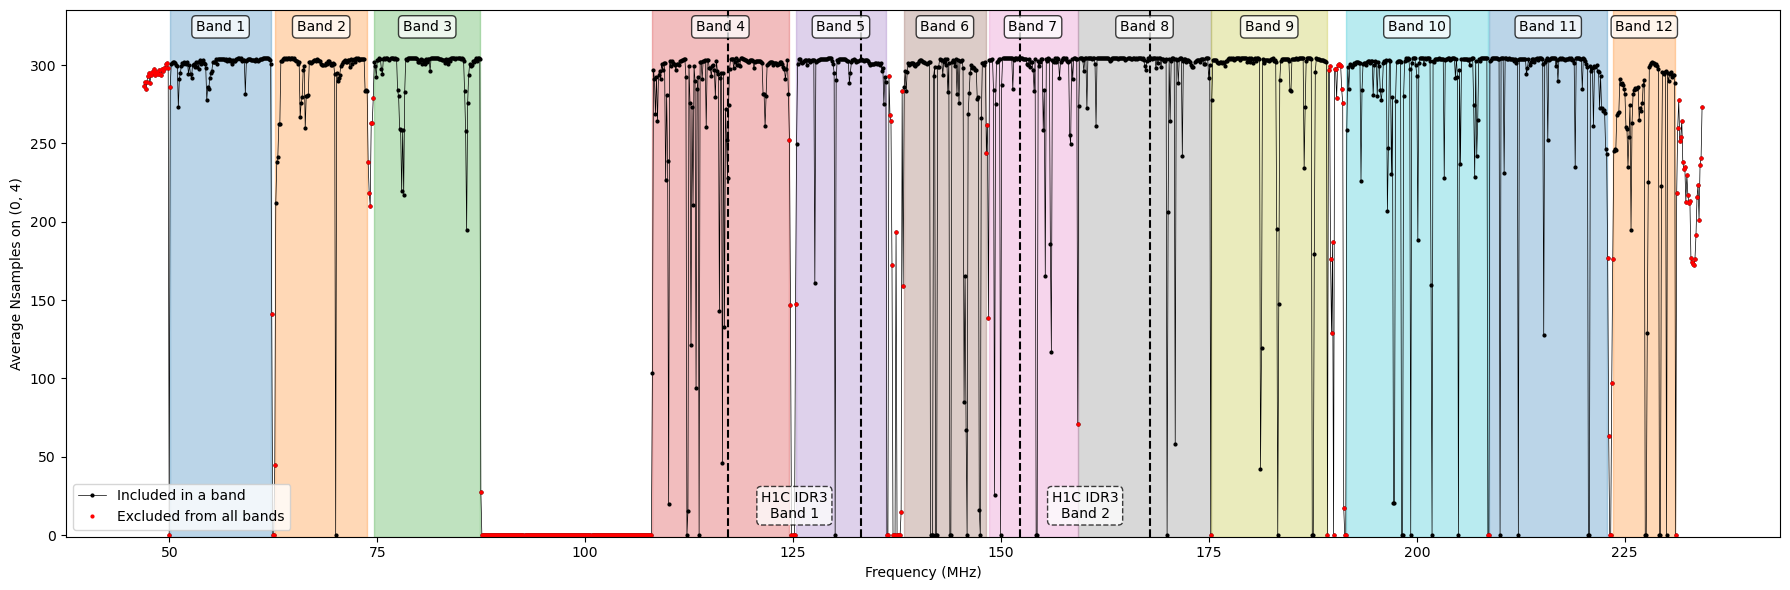

In [17]:
if PLOT: plot_bands()

## Figure out slicing

In [18]:
# figure out high and low bands
FM_ind = np.argmin(np.abs(data.freqs - FM_CUT_FREQ))
unflagged_chans = np.argwhere(~np.all([np.all(flags[bl], axis=0) for bl in flags], axis=0)).squeeze()
low_band = slice(np.min(unflagged_chans), np.max(unflagged_chans[unflagged_chans < FM_ind]) + 1)
high_band = slice(np.min(unflagged_chans[unflagged_chans > FM_ind]), np.max(unflagged_chans) + 1)
print(f'Below FM Frequency Slice: {low_band}')
print(f'Above FM Frequency Slice: {high_band}')

# figure out the range of unflagged times for both polarizations
ORed_flags = np.all(flags[ANTPAIR + ('ee',)], axis=1) | np.all(flags[ANTPAIR + ('nn',)], axis=1)
tslice = slice(true_stretches(~ORed_flags)[0].start, true_stretches(~ORed_flags)[-1].stop)
print(f'Time Slice Excluded Edge Flags: {tslice}')

Below FM Frequency Slice: slice(0, 333, None)
Above FM Frequency Slice: slice(501, 1536, None)
Time Slice Excluded Edge Flags: slice(121, 3949, None)


In [19]:
# FOR DIAGNOSTICS/DEBUGGING ONLY: unflag everything and set nsamples to the median
if NO_FLAGS_FLAT_NSAMPLES:
    for bl in [ANTPAIR + ('ee',), ANTPAIR + ('nn',)]:
        flags[bl][tslice, :] = False
        nsamples[bl][tslice, :] = np.median([nsamples[bl][tslice, :] for bl in [ANTPAIR + ('ee',), ANTPAIR + ('nn',)]])
    
# FOR DIAGNOSTICS/DEBUGGING ONLY: make all the autos a flat 10,000 Jy 
if FLAT_AUTOS:
    for bl in data:
        if bl[0] == bl[1]:
            data[bl] = 10000 * np.ones_like(data[bl])

## Figure out per-band fringe-rate filter ranges

In [20]:
# load relevant FR spectrum vs. frequency and associated metadata
with h5py.File(FR_SPECTRA_FILE, "r") as h5f:
    metadata = h5f["metadata"]
    bl_to_index_map = {tuple(ap): int(index) for index, antpairs in metadata["baseline_groups"].items() for ap in antpairs}
    spectrum_freqs = metadata["frequencies_MHz"][()] * 1e6
    m_modes = metadata["erh_mode_integer_index"][()]
    if ANTPAIR in bl_to_index_map:
        mmode_spectrum = h5f["erh_mode_power_spectrum"][:, :, bl_to_index_map[ANTPAIR]]
    else:
        # If ANTPAIR is not in the FR_SPECTRA_FILE, but the reverse is, also reverse the spectrum
        mmode_spectrum = h5f["erh_mode_power_spectrum"][:, :, bl_to_index_map[ANTPAIR[::-1]]]
        m_modes *= -1

In [21]:
# convert to fringe rate, accouting for the fact that we have less than 24 hours of LST
def m2f(m_modes):
    # Convert m-modes to fringe-rates in mHz.
    return m_modes / units.sday.to(units.ks)
times_ks = (data.times[tslice] - data.times[0] + np.median(np.diff(data.times))) * units.day.to(units.ks)
m2f_phasors = np.exp(2j * np.pi * m2f(m_modes)[None, :] * times_ks[:, None])
m2f_mixer = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(m2f_phasors, axes=0), axis=0), axes=0)
# f is fringe rate, m is m-mode, n is nu (i.e. freqeuency)
fr_spectrum = np.abs(np.einsum('fm,mn,mf->fn', m2f_mixer, mmode_spectrum, m2f_mixer.T.conj()))

In [22]:
# interpolate to all frequencies in data
interp_fr_spectrum = interpolate.interp1d(spectrum_freqs, fr_spectrum, kind='cubic', fill_value='extrapolate')(data.freqs)    
frates = np.fft.fftshift(np.fft.fftfreq(len(times_ks), d=np.median(np.diff(times_ks))))

# perform window-weighted average over each band, then get lower and upper quantiles
fr_ranges = {}
fr_profiles = {}
frf_losses = {}
xtalk_overlaps = {}
for band, bs in zip(bands, band_slices):
    taper = dspec.gen_window(TAPER, len(data.freqs[bs]))
    band_avg_fr_spectrum = np.average(interp_fr_spectrum[:, bs], weights=taper, axis=1)
    band_avg_fr_spectrum /= np.sum(band_avg_fr_spectrum)
    fr_profiles[band] = band_avg_fr_spectrum
    cumsum_interpolator = interpolate.interp1d(np.cumsum(band_avg_fr_spectrum), frates)
    fr_ranges[band] = cumsum_interpolator(FR_QUANTILE_LOW), cumsum_interpolator(FR_QUANTILE_HIGH)
    
    # account for overlap between FR=0 notch and main beam FRF
    def overlap_frs(frs1, frs2):
        start = np.maximum(frs1[0], frs2[0])
        end = np.minimum(frs1[1], frs2[1])
        return (start, end) if start < end else None
    frate_interpolator = interpolate.interp1d(frates, np.cumsum(band_avg_fr_spectrum))
    frf_losses[band] = 1 - frate_interpolator(fr_ranges[band][1]) + frate_interpolator(fr_ranges[band][0])
    xtalk_overlaps[band] = overlap_frs(fr_ranges[band], [-XTALK_FR, XTALK_FR])
    if xtalk_overlaps[band] is not None:
        frf_losses[band] += frate_interpolator(xtalk_overlaps[band][1]) - frate_interpolator(xtalk_overlaps[band][0])    
    
def show_FR_table():
    table = pd.DataFrame({'Band': np.arange(len(bands)) + 1,
                          'Frequency Range (MHz)': [f'{f0:.1f} — {f1:.1f}' for f0, f1 in zip(min_freqs, max_freqs)],
                          f'Main Beam {FR_QUANTILE_LOW:.0%} — {FR_QUANTILE_HIGH:.0%}<br>Kept Fringe Rates (mHz)': [f'{frs[0]:.3f} to {frs[1]:.3f}' for frs in fr_ranges.values()],
                          f'Approximate Signal Loss with<br>{-XTALK_FR} to {XTALK_FR} mHz X-Talk Filter': [f'{loss:.0%}' for loss in frf_losses.values()],
                         })
    return table.style.hide().to_html()

# *Table 2: Fringe-Rate and Crosstalk Filtering Ranges and Losses*

Note that these losses are approximate and assume perfectly sharp filters. Extra extent in fringe-rate space (which is controlled by `FR_EIGENVAL_CUTOFF`) will reduce loss when performing the main beam fringe-rate filter (because it is a top hat). It will also will increase the loss due to the crosstalk filtering (because it is a notch) if and only if there's an overlap between the two filters.

TODO: As a future feature, we'd like to implement Bobby's full transfer-matrix formalism for figuring out the actual loss given the set of DPSS filters used here.

In [23]:
HTML(show_FR_table())

Band,Frequency Range (MHz),Main Beam 5% — 95%Kept Fringe Rates (mHz),Approximate Signal Loss with-0.01 to 0.01 mHz X-Talk Filter
1,50.2 — 62.2,-0.807 to -0.538,10%
2,62.7 — 73.8,-0.968 to -0.433,10%
3,74.6 — 87.4,-1.141 to -0.802,10%
4,108.0 — 124.5,-1.605 to -1.250,10%
5,125.4 — 136.2,-1.791 to -1.421,10%
6,138.3 — 148.2,-1.961 to -1.558,10%
7,148.5 — 159.2,-2.104 to -1.675,10%
8,159.3 — 175.2,-2.268 to -1.836,10%
9,175.3 — 189.2,-2.474 to -1.998,10%
10,191.5 — 208.5,-2.691 to -2.212,10%


## Plotting Functions

In [24]:
def sym_log_norm(to_plot, linthresh=10, clim=None):
    '''Convenience interface for matplotlib.colors.SymLogNorm'''
    if clim is None:
        return matplotlib.colors.SymLogNorm(linthresh, vmin=-np.nanmax(np.abs(to_plot)), vmax=np.nanmax(np.abs(to_plot)))
    else:
        return matplotlib.colors.SymLogNorm(linthresh, vmin=clim[0], vmax=clim[1])

In [25]:
def plot_waterfall(data, bl=(ANTPAIR + ('ee',)), flags=flags, nsamples=nsamples, tslice=tslice):
    '''Plots data (amplitude and phase) as well as nsamples waterfalls for a baseline.'''
    if tslice is None:
        tslice = slice(0, data[bl].shape[0], 1)
    lsts = np.where(data.lsts > data.lsts[-1], data.lsts - 2 * np.pi, data.lsts)[tslice] * 12 / np.pi
    extent = [data.freqs[0]/1e6, data.freqs[-1]/1e6, lsts[-1], lsts[0]]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 12), sharex=True, sharey=True, dpi=100)
    im = axes[0].imshow(np.where(flags[bl], np.nan, np.abs(data[bl]))[tslice], aspect='auto', norm=matplotlib.colors.LogNorm(), interpolation='none', cmap='inferno', extent=extent)
    fig.colorbar(im, ax=axes[0], location='top', pad=.02, label=f'{bl}: Amplitude (Jy)')

    im = axes[1].imshow(np.where(flags[bl], np.nan, np.angle(data[bl]))[tslice], aspect='auto', cmap='twilight', interpolation='none', extent=extent)
    fig.colorbar(im, ax=axes[1], location='top', pad=.02, label=f'{bl}: Phase (Radians)')

    im = axes[2].imshow(nsamples[bl][tslice], aspect='auto', interpolation='none', extent=extent)
    fig.colorbar(im, ax=axes[2], location='top', pad=.02, label=f'{bl}: Number of Samples')
    plt.tight_layout()

    for ax in axes:
        ax.set_ylabel('LST (Hours)')
        ax.set_xlabel('Frequency (MHz)')
        ax.set_yticklabels([f'{(int(val) if np.isclose(val, int(val)) else val) % 24:n}' for val in ax.get_yticks()])

    plt.tight_layout()

In [26]:
def plot_real_delay_vs_lst(data, bl=(ANTPAIR + ('ee',)), flags=None, xlim=[-1999, 1999], clim=None, linthresh=10, taper=TAPER, tslice=tslice):
    '''Plots the real part of the tapered FFT of the data in each power spectrum band as a function of delay and LST.'''
    if tslice is None:
        tslice = slice(0, data[bl].shape[0], 1)
    lsts = np.where(data.lsts > data.lsts[-1], data.lsts - 2 * np.pi, data.lsts)[tslice] * 12 / np.pi

    fig, axes = plt.subplots(1, len(bands), figsize=(28, 12), sharex=True, sharey=True, gridspec_kw={'wspace': .03}, dpi=100)
    for i, (ax, band, band_slice) in enumerate(zip(axes, bands, band_slices)):
        dfft = uvtools.utils.FFT(data[bl][tslice, band_slice], axis=1, taper=taper)
        delays = uvtools.utils.fourier_freqs(data.freqs[band_slice]) * 1e9
        to_plot = np.real(dfft)
        if flags is not None:
            flagged_times = np.all(flags[bl][tslice, band_slice], axis=1)
            to_plot[flagged_times, :] = np.nan
        if i == 0:
            _to_plot = copy.deepcopy(to_plot)
            ax.set_ylabel('LST (Hours)')
        im = ax.imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', norm=sym_log_norm(_to_plot, linthresh=linthresh, clim=clim),
                       extent=[delays[0], delays[-1], lsts[-1], lsts[0]])
        for dly in dly_filter_half_widths[0] * 1e9 * np.array([1, -1]):
            ax.axvline(dly, ls='--', color='k', lw=.5)
        for dly in inpaint_filter_half_widths[0] * 1e9 * np.array([1, -1]):
            ax.axvline(dly, ls=':', color='k', lw=.5)
        ax.set_xlim(xlim)
        ax.set_title(f'Band {i+1}:\n{band[0]}—{band[1]} MHz', fontsize=10)
        ax.set_xlabel('Delay (ns)')
        ax.set_yticklabels([f'{(int(val) if np.isclose(val, int(val)) else val) % 24:n}' for val in ax.get_yticks()])

    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', label=f'Re$[\widetilde{{V}}_{{{bl}}}]$ (Jy)')

In [27]:
def plot_dly_vs_fr(data, bl=(ANTPAIR + ('ee',)), xlim=[-1999, 1999], ylim=[-5, 5], clim=None, tslice=tslice, taper=TAPER):
    '''Plots the magnitude of the 2D tapered FFT of the data in each power spectrum band as a function of delay and FR.
    Also shows the foreground filtering delay, the main beam range of FRs, and the expected shape of mutual coupling.'''
    fig, axes = plt.subplots(1, len(bands), figsize=(28, 6), sharex=True, sharey=True, gridspec_kw={'wspace': .03}, dpi=100)
    if tslice is None:
        tslice = slice(0, data[bl].shape[0], 1)

    to_plots = []
    for i, (ax, band, band_slice) in enumerate(zip(axes, bands, band_slices)):
        dfft = uvtools.utils.FFT(data[bl][:, band_slice], axis=1, taper=TAPER)
        delays = uvtools.utils.fourier_freqs(data.freqs[band_slice]) * 1e9
        frates = uvtools.utils.fourier_freqs((data.times[tslice] - data.times[0]) * 24 * 60 * 60) * 1000

        dfft2 = uvtools.utils.FFT(dfft[tslice, :], axis=0, taper=TAPER)

        to_plot = np.abs(dfft2)
        to_plots.append(to_plot)
        if i == 0:
            _to_plot = copy.deepcopy(to_plot)
            ax.set_ylabel('Fringe Rate (mHz)')        
        im = ax.imshow(to_plot, interpolation='none', aspect='auto', cmap='turbo', 
                       norm=matplotlib.colors.LogNorm(vmin=(clim[0] if clim is not None else np.min(_to_plot)), 
                                                      vmax=(clim[1] if clim is not None else np.max(_to_plot))),
                       extent=[delays[0], delays[-1], frates[-1], frates[0]])
        for dly in dly_filter_half_widths[0] * 1e9 * np.array([1, -1]):
            ax.axvline(dly, ls='--', color='k', lw=.5)
        for dly in inpaint_filter_half_widths[0] * 1e9 * np.array([1, -1]):
            ax.axvline(dly, ls=':', color='k', lw=.5)
        for fr in fr_ranges[band]:# + (pol,)]:
            ax.axhline(fr, ls='--', color='k', lw=.5)

        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.set_title(f'Band {i+1}:\n{band[0]}—{band[1]} MHz', fontsize=10)
        ax.set_xlabel('Delay (ns)')

    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', label=f'$|\widetilde{{V}}_{{{bl}}}|$ (Jy)')
    
    omega_earth = 2 * np.pi / (24 * 3600) #rad/s
    hera_dec = -30.72152612068925 * np.pi / 180
    def calculate_fr(bl_vec, freq):
        """bl_vec in meters, freq in Hz, returns fr in mHz"""
        bl_we = bl_vec[0]
        fr = -bl_we * omega_earth * freq * np.cos(hera_dec) / constants.c * 1e3
        return fr
    def max_fr(tau, freq):
        """takes in tau in ns, freq in Hz, returns corresponding max fringe rate in mHz"""
        return omega_earth * freq * tau * np.cos(hera_dec) * 1e-6 # mHz 

    b_ij = data.antpos[bl[1]] - data.antpos[bl[0]]
    for i in range(len(bands)):
        freq = np.mean(bands[i]) * 1e6
        axes[i].plot(delays, max_fr(delays, freq) + calculate_fr(b_ij, freq), color='k', ls='--', lw=.5)
        axes[i].plot(delays, -max_fr(delays, freq) + calculate_fr(b_ij, freq), color='k', ls='--', lw=.5)

## Filtering and Post-Processing Functions

In [28]:
def delay_filter(data, wgts, filter_centers, filter_half_widths, eigenval_cutoff, cache={}, bls=None, zeros_where_zero_wgt=True):
    '''This function performs a high-pass delay filter, removing the wedge plus some buffer. It also performs inpainting with the same delay.'''
    dly_filt_data = copy.deepcopy(data)
    inpainted_data = copy.deepcopy(data)
    if bls is None:
        bls = [ANTPAIR + (pol,) for pol in ['ee', 'nn']]
    
    for bl in bls:
        d_mdl = np.zeros_like(dly_filt_data[bl])
        for band in [low_band, high_band]:
            d_mdl[:, band], _, info = dspec.fourier_filter(data.freqs[band], dly_filt_data[bl][:, band], wgts=wgts[bl][:, band], filter_centers=filter_centers, 
                                                           filter_half_widths=filter_half_widths, mode='dpss_solve', 
                                                           eigenval_cutoff=[eigenval_cutoff], suppression_factors=[eigenval_cutoff], 
                                                           max_contiguous_edge_flags=len(data.freqs), cache=cache)
        if zeros_where_zero_wgt:
            dly_filt_data[bl] = np.where(wgts[bl] == 0, 0, dly_filt_data[bl] - d_mdl)
        else:
            dly_filt_data[bl] = dly_filt_data[bl] - d_mdl
        inpainted_data[bl] = np.where(wgts[bl] == 0, d_mdl, data[bl])
    
    return dly_filt_data, inpainted_data

In [29]:
def xtalk_filter(data, wgts, xtalk_fr=XTALK_FR, tslice=tslice, cache={}, bls=None):
    '''This function performs a high-pass filter in fringe rate, removing some small range around the 0 FR mode.'''
    xtalk_filt_data = copy.deepcopy(data)
    if bls is None:
        bls = [ANTPAIR + (pol,) for pol in ['ee', 'nn']]    
    
    for bl in bls:
        if tslice is None:
            tslice = slice(0, data[bl].shape[0], 1)

        d_mdl, _, info = dspec.fourier_filter(data.times[tslice] * 24 * 60 * 60, data[bl][tslice], 
                                              wgts=wgts[bl][tslice, :], filter_centers=[0], 
                                              filter_half_widths=[xtalk_fr / 1000], mode='dpss_solve', 
                                              eigenval_cutoff=[FR_EIGENVAL_CUTOFF], suppression_factors=[FR_EIGENVAL_CUTOFF], 
                                              max_contiguous_edge_flags=len(data.times), cache=cache, filter_dims=0)

        xtalk_filt_data[bl][tslice, :] = np.where(wgts[bl][tslice, :] == 0, 0, xtalk_filt_data[bl][tslice, :] - d_mdl)
    return xtalk_filt_data

In [30]:
def main_beam_FR_filter(data, wgts, tslice=tslice, cache={}, bls=None, suppression_factors=[FR_EIGENVAL_CUTOFF]):
    '''This function performs fringe rate filtering, keeping a range determined by fr_ranges for each band.'''
    frf_data = copy.deepcopy(data)
    if bls is None:
        bls = [ANTPAIR + (pol,) for pol in ['ee', 'nn']]
    
    for bl in bls:    
        if tslice is None:
            tslice = slice(0, data[bl].shape[0], 1)

    
        d_mdl = np.zeros_like(data[bl])
        for band, band_slice in zip(bands, band_slices):
            d_mdl[tslice, band_slice], _, _ = dspec.fourier_filter(data.times[tslice] * 24 * 60 * 60,
                                                                   data[bl][tslice, band_slice],
                                                                   wgts=wgts[bl][tslice, band_slice],
                                                                   filter_centers=[np.mean(fr_ranges[band]) / 1000],
                                                                   filter_half_widths=[np.diff(fr_ranges[band]) / 2 / 1000], 
                                                                   mode='dpss_solve', eigenval_cutoff=[FR_EIGENVAL_CUTOFF], 
                                                                   suppression_factors=suppression_factors, 
                                                                   max_contiguous_edge_flags=len(data.times), cache=cache, filter_dims=0)
        frf_data[bl] *= 0
        frf_data[bl][tslice, :] = np.where(wgts[bl][tslice, :] == 0, 0, d_mdl[tslice, :])
    
    return frf_data

In [31]:
def form_pseudostokes(data=None, flags=None, nsamples=None):
    # TODO: fix this to use pol_convention from data properly
    # TODO: deprecate this in favor of a version in hera_pspec 
    '''This function creates pseudo-Stokes I and Q versions corresponding to the ee and nn entries
    in the input data containers, and stores them in the same data containers.'''
    # data are averaged (or diffed in the case of pQ)
    if data is not None:
        for antpair in data.antpairs():
            data[antpair + ('pI',)] = (data[antpair + ('ee',)] + data[antpair + ('nn',)]) / 2
            data[antpair + ('pQ',)] = (data[antpair + ('ee',)] - data[antpair + ('nn',)]) / 2

    # flags are ORed
    if flags is not None:
        for antpair in flags.antpairs():            
            flags[antpair + ('pI',)] = flags[antpair + ('ee',)] | flags[antpair + ('nn',)]
            flags[antpair + ('pQ',)] = flags[antpair + ('ee',)] | flags[antpair + ('nn',)]

    # nsamples are combined to produce the correct variance for pI and pQ. 
    # In the limit where the two pols have the same nsamples, it's just the sum.
    if nsamples is not None:
        for antpair in nsamples.antpairs():
            nsamples[antpair + ('pI',)] = 4 * (nsamples[antpair + ('ee',)]**-1 + nsamples[antpair + ('nn',)]**-1)**-1
            nsamples[antpair + ('pQ',)] = 4 * (nsamples[antpair + ('ee',)]**-1 + nsamples[antpair + ('nn',)]**-1)**-1

In [32]:
def deinterleave_datacontainer(dc, ninterleave=NINTERLEAVE, tslice=slice(None)):
    '''Breaks datacontainers into ninterleave separate containers and returns a list of deinterleaved datacontainers.
    Also updates .times and .lsts attributes. Integrations at the end that do not evenly divide are dropped.'''
    deint_dcs = []
    for i in range(ninterleave):
        islice = slice(i, (len(dc.times[tslice]) // ninterleave) * ninterleave, ninterleave)  # ensures all slices have same shape
        new_dc = copy.deepcopy(dc)
        new_dc.times = dc.times[tslice][islice]
        new_dc.lsts = dc.lsts[tslice][islice]
        for bl in new_dc:
            new_dc[bl] = dc[bl][tslice, :][islice, :]
        deint_dcs.append(new_dc)
    return deint_dcs

In [33]:
def timeavg_data(data, flags, nsamples, Navg=int(np.round(AVERAGING_TIME / (dt * NINTERLEAVE))), pols=None, tslice=slice(None), rephase=True):
    '''Performs coherent averaging of Navg integrations, rephasing to the common phase center.'''
    avg_data = datacontainer.DataContainer({})
    avg_flags = datacontainer.DataContainer({})
    avg_nsamples = datacontainer.DataContainer({})
    
    # perform time-averaging
    for bl in data:
        if (pols is not None) and (bl[2] not in pols):
            continue
        bl_vec =  data.antpos[bl[0]] - data.antpos[bl[1]]
        (avg_data[bl], 
         avg_flags[bl], 
         avg_nsamples[bl], 
         avg_lsts, 
         extra) = frf.timeavg_waterfall(data[bl][tslice, :], Navg,
                                        flags=np.zeros_like(flags[bl][tslice, :]),
                                        nsamples=nsamples[bl][tslice, :], 
                                        extra_arrays={'times': data.times[tslice]},
                                        lsts=data.lsts[tslice], freqs=data.freqs,
                                        rephase=rephase, bl_vec=bl_vec, verbose=False)
        avg_flags[bl][avg_nsamples[bl] == 0] = True
    
    # attach relevant quantities to datacontainer
    for dc in (avg_data, avg_flags, avg_nsamples):
        dc.freqs = copy.deepcopy(data.freqs)
        dc.antpos = copy.deepcopy(data.antpos)
        dc.lsts = avg_lsts
        dc.times = extra['avg_times']
    return avg_data, avg_flags, avg_nsamples 

## Figure out delay filter properties

In [34]:
bl_vec = (data.antpos[ANTPAIR[1]] - data.antpos[ANTPAIR[0]])
bl_len = np.linalg.norm(bl_vec[:2]) / constants.c
dly_filter_centers, dly_filter_half_widths = vis_clean.gen_filter_properties(ax='freq', horizon=DLY_FILT_HORIZON, standoff=DLY_FILT_STANDOFF, 
                                                                             min_dly=DLY_FILT_MIN_DLY, bl_len=bl_len)
inpaint_filter_centers, inpaint_filter_half_widths = vis_clean.gen_filter_properties(ax='freq', horizon=INPAINT_HORIZON, standoff=INPAINT_STANDOFF, 
                                                                                     min_dly=INPAINT_MIN_DLY, bl_len=bl_len)

## If desired, propagate flags on a channel to all times that will be coherently averaged together

This is primarily useful in the delay-filtered case with flags, where we want to avoid different interleaves having different flagging patterns.

In [35]:
def factored_flags(flag_array, tslice=slice(None)):
    '''If any channel is flagged in a boolean flag_array, flag all times for that channel unless the channel flag comes from an entirely flagged time.'''
    out_flags = np.zeros_like(flag_array)
    flagged_times = np.all(flag_array, axis=1)
    out_flags[flagged_times, :] = True
    if not np.all(flagged_times) :
        chan_flags = np.any(flag_array[~flagged_times], axis=0)
        out_flags[:, chan_flags] = True
    return out_flags

if FLAG_COHERENT_CHUNKS:
    Nchunk = int(AVERAGING_TIME // (dt * NINTERLEAVE)) * NINTERLEAVE
    for ci in range(int(np.ceil(flags[bl][tslice].shape[0] / Nchunk))):
        for bl in flags:
            flags[bl][tslice][ci * Nchunk:(ci + 1) * Nchunk] = factored_flags(flags[bl][tslice][ci * Nchunk:(ci + 1) * Nchunk], tslice=tslice)

## Perform inpainting and/or delay-filtering

In [36]:
def per_band_avg_nsamples(nsamples, band_slices):
    '''Create new datacontainer where nsamples has been averaged per-integration in band_slices.
    This is an approximate way to account for the fact that inpainted data is considered Nsamples=0.'''
    out_nsamples = copy.deepcopy(nsamples)
    for bl in out_nsamples:
        for band in band_slices:
            for i in range(out_nsamples[bl].shape[0]):
                out_nsamples[bl][i, band] = np.mean(out_nsamples[bl][i, band])
    return out_nsamples

In [37]:
def build_weights(data, flags, nsamples, wgt_by_avg_nsamples=False, band_slices=[]):
    '''Construct weights proportional to inverse noise variance (i.e. Nsamples / Autocorr^2).
    If wgt_by_avg_nsamples is True, average Nsamples in each subband (defined with band_slices).
    This avoids the introduction of spectral structure.'''
    wgts = copy.deepcopy(data)
    if wgt_by_avg_nsamples:
        nsamples_here = per_band_avg_nsamples(nsamples, band_slices)
    else:
        nsamples_here = copy.deepcopy(nsamples)        
        
    for bl in wgts:               
        auto_bl = auto_antpair + bl[2:]
        wgts[bl] = np.abs(np.where(flags[bl], 0, data[auto_bl]**-2 * nsamples_here[bl]))
        wgts[bl] /= np.nanmean(np.where(flags[bl], np.nan, wgts[bl]))  # avoid dynamic range issues
        wgts[bl][~np.isfinite(wgts[bl])] = 0
    
    return wgts

In [38]:
# Build weights for delay-filter and/or inpainting that don't involve any Nsample averaging
freq_filt_wgts = build_weights(data, flags, nsamples) 

invalid value encountered in power


In [39]:
# Inpaint autocorrelations to allow for prediction of thermal noise on every channel
if not ALREADY_INPAINTED:
    _, data = delay_filter(data, freq_filt_wgts, inpaint_filter_centers, inpaint_filter_half_widths, INPAINT_EIGENVAL_CUTOFF, 
                           bls=[auto_antpair + (pol,) for pol in ['ee', 'nn']])

In [40]:
filt_data = copy.deepcopy(data)
filt_flags = copy.deepcopy(flags)
filt_nsamples = copy.deepcopy(nsamples)

In [41]:
# This cell replaces data with appropriate noise, which is useful for debugging
if USE_SIMULATED_NOISE:
    np.random.seed(21)

    reds = redcal.get_reds(filt_data.data_antpos, pols=['ee', 'nn'], include_autos=True)
    red_inpainted = datacontainer.RedDataContainer(data, reds=reds)

    for pol in ['ee', 'nn']:
        bl = ANTPAIR + (pol,)
        predicted_var = noise.predict_noise_variance_from_autos(bl, red_inpainted, nsamples=nsamples)
        predicted_var = np.where(~np.isfinite(predicted_var), 0, predicted_var)
        filt_data[bl] = np.sqrt(predicted_var) / 2**.5 * (np.random.randn(hd.Ntimes, hd.Nfreqs) + 1.0j * np.random.randn(hd.Ntimes, hd.Nfreqs))

In [42]:
# Inpaint crosses
if PERFORM_INPAINT:
    _, filt_data = delay_filter(data, freq_filt_wgts, inpaint_filter_centers, inpaint_filter_half_widths, INPAINT_EIGENVAL_CUTOFF)
    for pol in ['ee', 'nn']:
        bl = ANTPAIR + (pol,)
        for band in [high_band, low_band]:
            for i in range(filt_flags[bl].shape[0]):
                if not np.all(filt_flags[bl][i, band]):
                    filt_flags[bl][i, band] = False
inpainted = copy.deepcopy(filt_data)

In [43]:
# perform delay filtering on crosses
if PERFORM_DLY_FILT:
    filt_data, _ = delay_filter(inpainted, freq_filt_wgts, dly_filter_centers, dly_filter_half_widths, DLY_FILT_EIGENVAL_CUTOFF, zeros_where_zero_wgt=False)

In [44]:
# Recompute time filter flags, averaging nsamples in subbands if desired (this also applies to further processing)
if USE_BAND_AVG_NSAMPLES:
    filt_nsamples = per_band_avg_nsamples(filt_nsamples, band_slices)
    
time_filt_wgts = build_weights(filt_data, filt_flags, filt_nsamples)

invalid value encountered in power


In [45]:
# perform deinterleaving
deint_filt_data = deinterleave_datacontainer(filt_data, ninterleave=NINTERLEAVE, tslice=tslice)
deint_flags = deinterleave_datacontainer(filt_flags, ninterleave=NINTERLEAVE, tslice=tslice)
deint_nsamples = deinterleave_datacontainer(filt_nsamples, ninterleave=NINTERLEAVE, tslice=tslice)
deint_wgts = deinterleave_datacontainer(time_filt_wgts, ninterleave=NINTERLEAVE, tslice=tslice)

In [46]:
# precomputation for rephasing before coherent averaging, ensuring all interleaves are rephased to the same lst
bl_vec = {bl: data.antpos[bl[0]] - data.antpos[bl[1]] for bl in [ap + (pol,) for ap in data.antpairs() for pol in ['ee', 'nn', 'pI', 'pQ']]}
Navg = int(AVERAGING_TIME // (dt * NINTERLEAVE))
n_avg_int = int(np.ceil(len(deint_filt_data[0].lsts) / Navg))
target_lsts = [np.mean([np.unwrap(d.lsts)[i * Navg:(i+1) * Navg] for d in deint_filt_data]) for i in range(n_avg_int)]

In [47]:
# Initialize arrays for storing intermediate and final results for each interleave
deint_avg_data, deint_avg_flags, deint_avg_nsamples = [], [], []
deint_xtalk_filt_data, deint_frf_data = [], []

for d, f, n, w in zip(deint_filt_data, deint_flags, deint_nsamples, deint_wgts):
    # Perform full time-filtering
    if not SKIP_XTALK_AND_FRF:
        # Crosstalk filtering of FR=0 mode
        xtalk_filt_d = xtalk_filter(d, w, tslice=None)
        deint_xtalk_filt_data.append(xtalk_filt_d)
        
        # Main beam FRF and forming pseduostokes
        frf_d = main_beam_FR_filter(xtalk_filt_d, w, tslice=None)
        deint_frf_data.append(frf_d)
    else:
        deint_xtalk_filt_data.append(d)
        deint_frf_data.append(d)
    
    # Form pseudo-Stokes I and Q from ee and nn
    form_pseudostokes(deint_frf_data[-1], f, n)
    
    # Coherent time-averaging, rephasing to a set of lsts that's consistent across interleaves
    dlst = [target_lsts[i] - l for i in range(n_avg_int) for l in np.unwrap(d.lsts)[i * Navg:(i+1) * Navg]]
    rephased_frf_d = copy.deepcopy(deint_frf_data[-1])
    utils.lst_rephase(rephased_frf_d, bl_vec, d.freqs, dlst, lat=hd.telescope_location_lat_lon_alt_degrees[0], inplace=True)
    avg_d, avg_f, avg_n = timeavg_data(rephased_frf_d, f, n, Navg=int(AVERAGING_TIME // (dt * NINTERLEAVE)), pols=['pI', 'pQ'], rephase=False)        
    
    # Store Results
    deint_avg_data.append(avg_d)
    deint_avg_flags.append(avg_f)
    deint_avg_nsamples.append(avg_n)    

divide by zero encountered in reciprocal
divide by zero encountered in reciprocal


# Calculate FRF noise covariances

## First check that the alternate FRF operator doesn't do something insane

In [48]:
def lst_rad_to_hours(lsts_rad, tslice=slice(None)):
    lsts_hrs = np.where(lsts_rad > lsts_rad[-1], lsts_rad - 2 * np.pi, lsts_rad)[tslice] * 12 / np.pi
    
    return lsts_hrs

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_frop_wrapper(pol="nn", stream_ind=0, band_ind=0, t_avg=AVERAGING_TIME, 
                     rephase=True, wgt_tavg_by_nsample=True, nsamples=None, bl_vec=None,
                     dlst=None, coherent_avg=True):
    
    bl=(ANTPAIR[0], ANTPAIR[1], pol)
    band = bands[band_ind]
    band_slice = band_slices[band_ind]
    Nfreqs = band_slice.stop - band_slice.start

    weights=deint_wgts[stream_ind][bl][:, band_slice]
    times = np.modf(single_bl_times[tslice][stream_ind::4])[0] * 24 * 3600
    times = times - times[0]


    
    frop = FRF_cov_calc.get_frop(times, filter_cent_use=[np.mean(fr_ranges[band]) / 1000], 
                                 filter_half_wid_use=[np.diff(fr_ranges[band]) / 2 / 1000], 
                                 freqs=data.freqs[band_slice], t_avg=t_avg,
                                 cutoff=FR_EIGENVAL_CUTOFF, weights=weights,
                                 rephase=rephase, wgt_tavg_by_nsample=wgt_tavg_by_nsample,
                                 nsamples=nsamples, bl_vec=bl_vec, dlst=dlst,
                                 coherent_avg=coherent_avg)
    return frop

def get_alt_frf_dat(pol="nn", stream_ind=0, band_ind=0, t_avg=AVERAGING_TIME, 
                    rephase=True, wgt_tavg_by_nsample=True, nsamples=None, bl_vec=None,
                    dlst=None, coherent_avg=True):
    
    bl=(ANTPAIR[0], ANTPAIR[1], pol)
    band = bands[band_ind]
    band_slice = band_slices[band_ind]
    
    frop = get_frop_wrapper(pol=pol, stream_ind=stream_ind, band_ind=band_ind, t_avg=t_avg,
                            rephase=rephase, wgt_tavg_by_nsample=wgt_tavg_by_nsample,
                            nsamples=nsamples, bl_vec=bl_vec, dlst=dlst, coherent_avg=coherent_avg)

    deint_xtalk_filt_data_test = deint_xtalk_filt_data[stream_ind][bl][:, band_slice]
    deint_frf_data_test = deint_frf_data[stream_ind][bl][:, band_slice]
    alt_frf_data = (frop * deint_xtalk_filt_data_test).sum(axis=1)
    
    return deint_frf_data_test, alt_frf_data

def plot_streams(test_data, alt_data, band_ind=0, amp=True, linthresh=1e-6):
    band_slice = band_slices[band_ind]

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[12, 8])
    
    

    for stream_ind in range(4):
        if amp:
            dat_plot = np.abs(alt_data[stream_ind] / test_data[stream_ind]) - 1
        else:
            dat_plot = np.angle(alt_data[stream_ind] / test_data[stream_ind])

        
        lst_use = lst_rad_to_hours(deint_frf_data[stream_ind].lsts)
        freq_low, freq_high = bands[band_ind]
        
        im = ax[stream_ind].matshow(dat_plot, norm=matplotlib.colors.SymLogNorm(linthresh=linthresh),
                                    aspect="auto", extent=(freq_low, freq_high, lst_use[-1], lst_use[0]),
                                    cmap="coolwarm",)
        ax[stream_ind].set_title(f"Stream {stream_ind}")
        ax[stream_ind].set_xlabel("Frequency (MHz)")
        ax[stream_ind].set_ylabel("LST (hours)")
        
        divider = make_axes_locatable(ax[stream_ind])
        axBar = divider.append_axes("bottom", '5%', pad='7%')
        axHist = divider.append_axes("bottom", '30%', pad='14%')
        
        cbar = plt.colorbar(im, cax=axBar, orientation='horizontal')
        amin = np.log10(np.nanmin(np.abs(dat_plot)))
        amax = np.log10(np.nanmax(np.abs(dat_plot)))
        axHist.hist(np.abs(dat_plot).flatten(), bins=np.logspace(amin, amax, num=100), histtype="step", log=True)
        axHist.set_xscale("log")
        if amp:
            label = r"$|\frac{|V|_\mathrm{alt}}{|V|_\mathrm{pipe}} - 1|$"
        else:
            label = r"$|\Delta\phi|$ (rad)"
        axHist.set_xlabel(label, fontsize=12)
        
    return
    

In [50]:
band_ind = 0

deint_frf_data_test = []
alt_frf_data = []
for stream_ind in range(4):

    deint_frf_data_test_stream, alt_frf_data_stream = get_alt_frf_dat(stream_ind=stream_ind, band_ind=band_ind,
                                                                      t_avg=40., rephase=False, 
                                                                      wgt_tavg_by_nsample=False,
                                                                      coherent_avg=True)
    deint_frf_data_test.append(deint_frf_data_test_stream)
    alt_frf_data.append(alt_frf_data_stream)

invalid value encountered in divide


invalid value encountered in divide


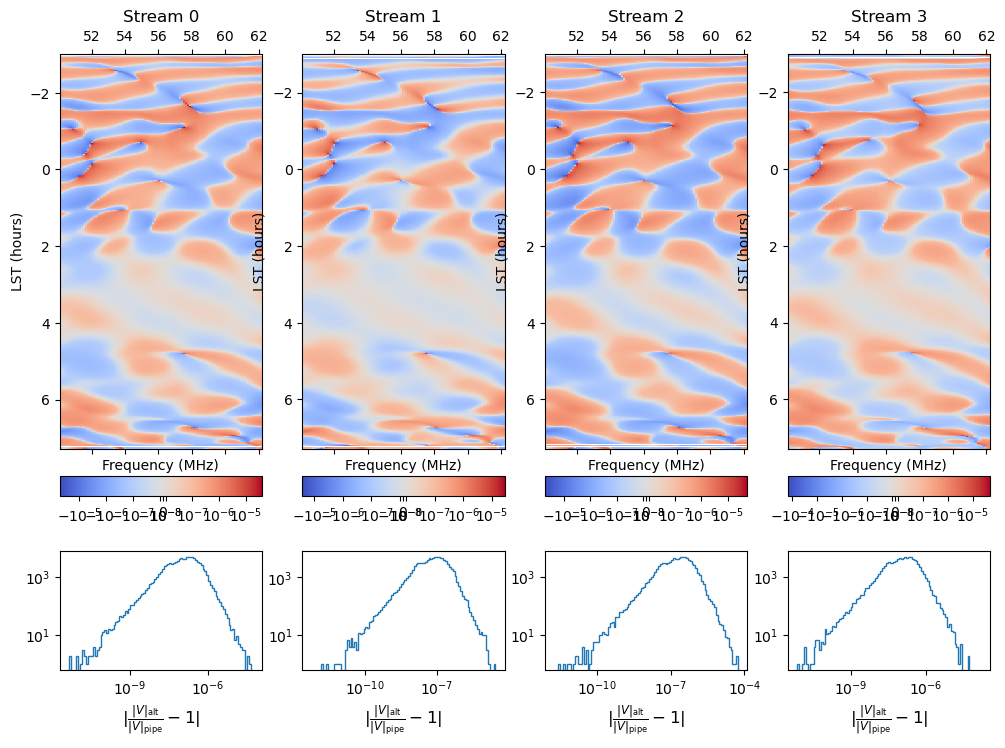

In [51]:


plot_streams(deint_frf_data_test, alt_frf_data, amp=True, linthresh=1e-7)

invalid value encountered in divide


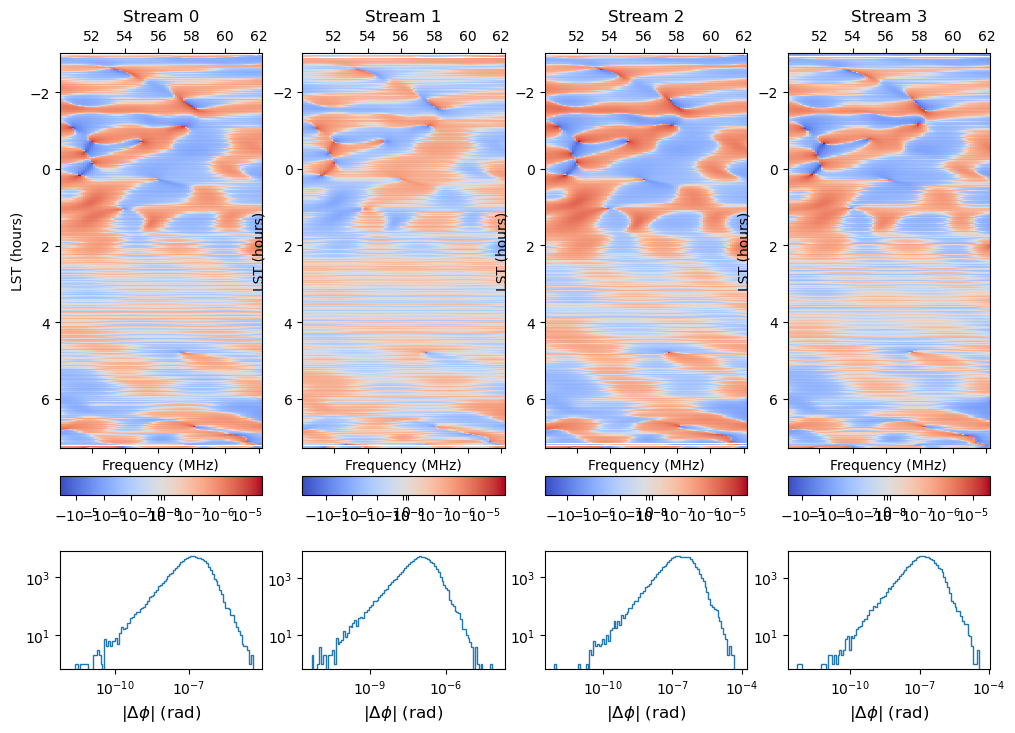

In [52]:
plot_streams(deint_frf_data_test, alt_frf_data, amp=False, linthresh=1e-7)

### TODO: Fix nsample weighting here and see if it makes a difference

In [58]:
def get_alt_coavg_dat(stream_ind=0, band_ind=0):

    dlst = [target_lsts[i] - l for i in range(n_avg_int) for l in np.unwrap(deint_filt_data[stream_ind].lsts)[i * Navg:(i+1) * Navg]]
    dlst = np.array(dlst).flatten()

    _, alt_frf_nn = get_alt_frf_dat(t_avg=AVERAGING_TIME, 
                                    nsamples=deint_nsamples[0][(0, 4, "pI")][:, band_slices[band_ind]],
                                    bl_vec=bl_vec[(0, 4, "nn")], dlst=dlst,)
    _, alt_frf_ee = get_alt_frf_dat(pol="ee", t_avg=AVERAGING_TIME, 
                                    nsamples=deint_nsamples[0][(0, 4, "pI")][:, band_slices[band_ind]],
                                    bl_vec=bl_vec[(0, 4, "ee")], dlst=dlst,)

    alt_frf_pI = 0.5 * (alt_frf_nn + alt_frf_ee)
    
    return alt_frf_pI

In [59]:
alt_frf_pI = get_alt_coavg_dat()

# Have to fix this: the average over pols happens before coherent averaging
# That means the weights here are wrong
# Need to change get_frop so that it incorporates the average or sum over pols to pI

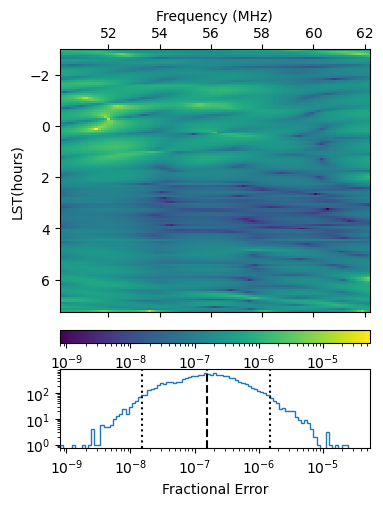

In [60]:
from scipy.stats import norm

dat_plot = np.abs(alt_frf_pI/deint_avg_data[0][(0, 4, "pI")][:, band_slices[0]] - 1)
coherent_lsts = lst_rad_to_hours(deint_avg_data[0].lsts)


extent = [bands[0][0], bands[0][1], coherent_lsts[-1], coherent_lsts[0]]
im = plt.matshow(dat_plot, norm=matplotlib.colors.LogNorm(), extent=extent)
plt.gca().xaxis.set_label_position('top')
plt.xlabel("Frequency (MHz)")
plt.ylabel("LST(hours)")
divider = make_axes_locatable(plt.gca())
axBar = divider.append_axes("bottom", '5%', pad='7%')
axHist = divider.append_axes("bottom", '30%', pad='10%')
        
cbar = plt.colorbar(im, cax=axBar, orientation='horizontal')
amin = np.log10(np.nanmin(np.abs(dat_plot)))
amax = np.log10(np.nanmax(np.abs(dat_plot)))
axHist.hist(dat_plot.flatten(), bins=np.logspace(amin, amax, num=100), histtype="step", log=True)
axHist.set_xscale("log")
axHist.set_xlabel("Fractional Error")
axHist.set_xlim([10**amin, 10**amax])
axHist.axvline(np.median(dat_plot), linestyle="--", color="black")
axHist.axvline(np.quantile(dat_plot, norm.cdf(-2)), linestyle=":", color="black")
axHist.axvline(np.quantile(dat_plot, norm.cdf(2)), linestyle=":", color="black")


# Close enough for now. Let's press on to covariance calculation.

In [73]:
def get_varis(pol="ee", band_ind=0, stream_ind=0):
    auto_bl = (0, 0, pol)
    cross_bl = (ANTPAIR[0], ANTPAIR[1], pol)
    band_slice = band_slices[band_ind]
    df = data.freqs[1] - data.freqs[0] # Hz
    dt = (data.times[1] - data.times[0]) * 24 * 60 * 60 # s at integration cadence not interleave cadence


    # Only have the (0,0) autos due to red_avg. so square the (0, 0)
    varis_num = np.abs(deint_filt_data[stream_ind][auto_bl][:, band_slice])**2 # No inpainting/delay filter so this is the right auto
    varis_den =  deint_nsamples[stream_ind][cross_bl][:, band_slice] * dt * df

    varis = varis_num / varis_den
    
    default_value = 0

    # Check all the infs are weighted to zero and replace with default value
    all_infs_zero = np.all(deint_wgts[stream_ind][cross_bl][:, band_slice][np.isinf(varis)]) == 0
    print(f"Are all infinite variance locations of zero weight?: {all_infs_zero}")

    varis[np.isinf(varis)] = default_value
    
    return varis

varis_ee = get_varis()
varis_nn = get_varis("nn")

Are all infinite variance locations of zero weight?: True
Are all infinite variance locations of zero weight?: True


divide by zero encountered in divide


In [72]:
band_ind=0

frop = get_frop_wrapper(pol="ee", stream_ind=stream_ind, band_ind=band_ind, t_avg=AVERAGING_TIME, 
                        rephase=True, wgt_tavg_by_nsample=True, 
                        nsamples=deint_nsamples[stream_ind][(ANTPAIR[0], ANTPAIR[1], "pI")][:, band_slices[band_ind]],
                        bl_vec=bl_vec[(ANTPAIR[0], ANTPAIR[1], "ee")],
                        dlst=dlst)

print(frop.shape)

(137, 957, 99)


In [74]:
cov = np.zeros([frop.shape[2], frop.shape[0], frop.shape[0]], dtype=complex)
for freq_ind in range(99):
    cov_ee_freq = np.tensordot((frop[:, :, freq_ind] * varis_ee[:, freq_ind]), frop[:, :, freq_ind].T.conj(), axes=1)
    cov_nn_freq = np.tensordot((frop[:, :, freq_ind] * varis_nn[:, freq_ind]), frop[:, :, freq_ind].T.conj(), axes=1)
    cov[freq_ind] = 0.25 * (cov_ee_freq + cov_nn_freq) # Doing the pI cov

In [75]:
len(deint_filt_data[0].lsts)

957

Text(0.5, 0, 'LST (hours)')

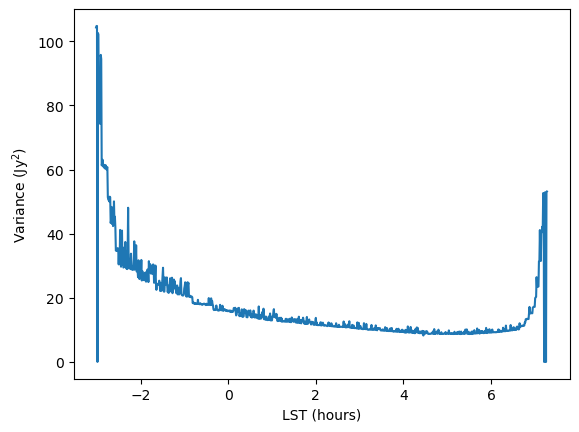

In [84]:
deint_lsts_hours = lst_rad_to_hours(deint_filt_data[0].lsts)

plt.plot(deint_lsts_hours, np.abs(varis[:, 50]))
#plt.plot(deint_nsamples[0][(ANTPAIR[0], ANTPAIR[1], "ee")][:, 50])
plt.ylabel(r"Variance (Jy$^2$)")
plt.xlabel("LST (hours)")


Text(0, 0.5, 'LST (hours)')

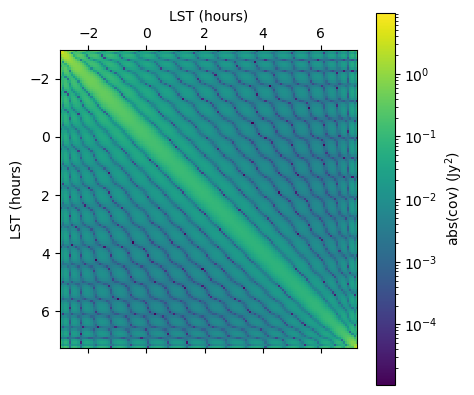

In [77]:
co_lst_extent = [coherent_lsts[0], coherent_lsts[-1], coherent_lsts[-1], coherent_lsts[0]]
cov_freq_ind = 50

plt.matshow(np.abs(cov[cov_freq_ind, :, :]), norm=matplotlib.colors.LogNorm(), 
            extent=co_lst_extent)
plt.colorbar(label=r"abs(cov) (Jy$^2$)")
plt.gca().xaxis.set_label_position('top')
plt.xlabel("LST (hours)")
plt.ylabel("LST (hours)")

Text(0, 0.5, 'LST (hours)')

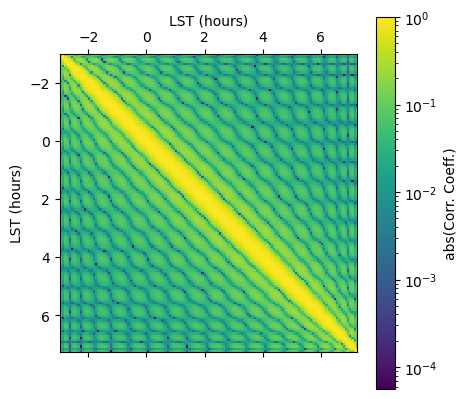

In [78]:
diags = cov[:, np.arange(137), np.arange(137)]
corr = cov / np.sqrt(diags[:, None] * diags[:, :, None])


plt.matshow(np.abs(corr[cov_freq_ind]), norm=matplotlib.colors.LogNorm(), extent=co_lst_extent)
plt.colorbar(label="abs(Corr. Coeff.)")
plt.gca().xaxis.set_label_position('top')
plt.xlabel("LST (hours)")
plt.ylabel("LST (hours)")

Text(0, 0.5, 'Correlation Amplitude')

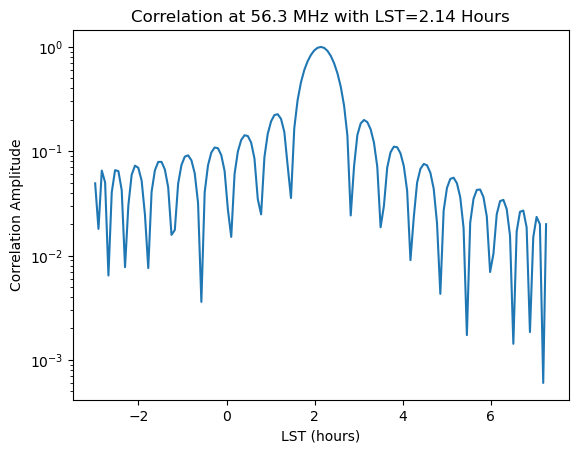

In [79]:
lst_ind = 68


plt.title(f"Correlation at %.1f MHz with LST=%.2f Hours" % (data.freqs[band_slices[0]][cov_freq_ind] * 1e-6, coherent_lsts[lst_ind]))
plt.plot(coherent_lsts, np.abs(corr[cov_freq_ind, lst_ind, :]))
plt.yscale("log")
plt.xlabel("LST (hours)")
plt.ylabel("Correlation Amplitude")

# For the PS covariance:

$p^{ij}_{\tau t t'} = x^{i}_{\tau t} (x^{j}_{\tau t'})^*$

$K^{ijkl}_{\tau\tau' t t' t'' t'''}=\langle p^{ij}_{\tau t t'}(p^{kl}_{\tau' t'' t'''})^*\rangle=\langle x^{i}_{\tau t} (x^{j}_{\tau t'})^*(x^{k}_{\tau' t''})^*x^{l}_{\tau't'''}\rangle = \delta^{ij}\delta^{kl}C^{(i)}_{\tau\tau t t'}C^{(k)}_{\tau'\tau' t'' t'''} + \delta^{ik}\delta^{jl}C^{(i)}_{\tau\tau' t t''}C^{(j)}_{\tau\tau' t' t'''}$ 

Note that there is also a pseudocovariance...

$\Gamma^{ijkl}_{\tau\tau' t t' t'' t'''}=\langle p^{ij}_{\tau t t'}p^{kl}_{\tau' t'' t'''}\rangle=\langle x^{i}_{\tau t} (x^{j}_{\tau t'})^*x^{k}_{\tau' t''}(x^{l}_{\tau't'''})^*\rangle = \delta^{ij}\delta^{kl}C^{(i)}_{\tau\tau t t'}C^{(k)}_{\tau'\tau' t'' t'''} + \delta^{il}\delta^{jk}C^{(i)}_{\tau\tau' t t'''}C^{(j)}_{\tau\tau' t' t''}$ 

The first term for both tensors is the "multiplying the same stream by itself" term (it's the term with the noise bias) that we are avoiding. The second term in each pair is asking whether the contributing pairs of streams are the same b/w the two delay spectra. For example, if we are asking about the delay spectra formed between streams (0, 1) and (1,2), we will get 0.

We often separate the real and imaginary part of the power spectrum. The complex (pseudo)-covariances above can be used to easily express the covariances of the real and imaginary parts of the power spectra, which I have derived in a separate note (but is also just a well-known result). The result for the real-real PS covariance is

$\kappa_{\Re, \Re} = \frac{1}{2}\Re(K + \Gamma)$ 

and for the imaginary-imaginary:

$\kappa_{\Im, \Im} = \frac{1}{2}\Re(K - \Gamma)$ 

To inspect the variance, note that we cannot simultaneously have 

$i=k$, $j=l$ and $i=l$, $j=k$ without being in a noise-bias case, meaning we need to isolate either the covariance or pseudocovariance term. For this to be a variance of a particular (stream-time)-pair, we must have 

$t=t''$, $t'=t'''$ AND $i=k$, $j=l$

OR

$t=t'''$, $t'=t''$ AND $i=l$, $j=k$

and no matter what we need $\tau=\tau'$. The reason for the OR condition above is that we need to respect that $x$ has both a stream and time index, and we can't swap which time is associated with which stream by just imposing a complex conjugate for example. In math:

$p^{ij}_{\tau t t'} \neq (p^{ij}_{\tau t' t})^*$

but it is true that

$p^{ij}_{\tau t t'} = (p^{ji}_{\tau t' t})^*$

Respecting this, we find that the variance of the real part is just given equivalently by either term above

$Var[\Re(p^{ij}_{\tau t t'})] = \frac{1}{2}\Re(C^{(i)}_{\tau\tau tt}C^{(j)}_{\tau\tau t't'})$ which is half the the variance of stream $i$ at time $t$ times the variance of stream $j$ at time $t'$.

Done out more explicitly:


$Var[\Re(p^{ij}_{\tau t t'})] = \frac{1}{4}\langle(p^{ij}_{\tau t t'} + (p^{ij}_{\tau t t'})^*)^2\rangle = \frac{1}{4}(2\Re(\Gamma^{ijij}_{\tau\tau tt'tt'}) + 2\Re(K^{ijij}_{\tau\tau tt'tt'})) = \frac{1}{2}\Re(C^{(i)}_{\tau\tau tt}C^{(j)}_{\tau\tau t't'})$

where we made use of the kronecker deltas to get rid of the pseudocovariance terms and then plugged in the nonzero covariance term.


In [ ]:
plt.plot(137**2 / np.sum(np.abs(corr)**2, axis=(1, 2)))

# Put a stop here for debugging purposes

In [ ]:
assert False

# *Figure 2: Waterfalls Before Delay Filtering and/or Inpainting*

In [ ]:
if PLOT:
    plot_waterfall(data, flags=flags)
    plot_real_delay_vs_lst(data, flags=flags, xlim=[-3999, 3999], clim=[-1e4, 1e4])
    plot_dly_vs_fr(data, xlim=[-1999, 1999], clim=[1e0, 1e5])

# *Figure 3: Waterfalls After Delay Filtering and/or Inpainting*

In [ ]:
if PLOT and (PERFORM_DLY_FILT or PERFORM_INPAINT):
    plot_waterfall(filt_data, flags=filt_flags, nsamples=nsamples)
    plot_real_delay_vs_lst(filt_data, flags=filt_flags, xlim=[-3999, 3999], clim=[-1e4, 1e4])
    plot_dly_vs_fr(filt_data, xlim=[-1999, 1999], clim=[1e0, 1e5])

# *Figure 4: First Set of De-Interleaved Waterfalls after Cross-Talk Filtering*

In [ ]:
if PLOT and not SKIP_XTALK_AND_FRF:
    plot_waterfall(deint_xtalk_filt_data[0], flags=deint_flags[0], nsamples=deint_nsamples[0], tslice=None)
    plot_real_delay_vs_lst(deint_xtalk_filt_data[0], flags=deint_flags[0], xlim=[-3999, 3999], clim=[-1e4, 1e4], tslice=None)
    plot_dly_vs_fr(deint_xtalk_filt_data[0], xlim=[-1999, 1999], clim=[1e0, 1e5], tslice=None)

# *Figure 5: First Set of De-Interleaved Waterfalls after Main-Beam Fringe-Rate Filtering*

In [ ]:
if PLOT and not SKIP_XTALK_AND_FRF:
    plot_waterfall(deint_frf_data[0], flags=deint_flags[0], nsamples=deint_nsamples[0], tslice=None)
    plot_real_delay_vs_lst(deint_frf_data[0], flags=deint_flags[0], xlim=[-3999, 3999], clim=[-2e2, 2e2], linthresh=1, tslice=None)
    plot_dly_vs_fr(deint_frf_data[0], xlim=[-1999, 1999], clim=[1e0, 1e5], tslice=None)

# *Figure 6: First Set of De-Interleaved Waterfalls after Forming Pseudo-Stokes I*

In [ ]:
if PLOT:
    plot_waterfall(deint_frf_data[0], bl=(ANTPAIR + ('pI',)), flags=deint_flags[0], nsamples=deint_nsamples[0], tslice=None)
    plot_real_delay_vs_lst(deint_frf_data[0], bl=(ANTPAIR + ('pI',)), flags=deint_flags[0], xlim=[-3999, 3999], clim=[-2e2, 2e2], linthresh=1, tslice=None)
    plot_dly_vs_fr(deint_frf_data[0], bl=(ANTPAIR + ('pI',)),  xlim=[-1999, 1999], clim=[1e0, 1e5], tslice=None)

# *Figure 7: First Set of De-Interleaved Waterfalls after Coherent Time Averaging*

In [ ]:
if PLOT:
    plot_waterfall(deint_avg_data[0], bl=(ANTPAIR + ('pI',)), flags=deint_avg_flags[0], nsamples=deint_avg_nsamples[0], tslice=None)
    plot_real_delay_vs_lst(deint_avg_data[0], bl=(ANTPAIR + ('pI',)), flags=deint_flags[0], xlim=[-3999, 3999], clim=[-2e2, 2e2], linthresh=1, tslice=None)
    plot_dly_vs_fr(deint_avg_data[0], bl=(ANTPAIR + ('pI',)), xlim=[-1999, 1999], clim=[1e0, 1e5], tslice=None)

## Prepare for power spectrum estimation

In [ ]:
# put results back into HERAData objects for use in hera_pspec (which works with UVData objects)
hds = []
for avg_data, avg_flags, avg_nsamples in zip(deint_avg_data, deint_avg_flags, deint_avg_nsamples):
    avg_hd = copy.deepcopy(hd)
    
    # select the right number of times and update time and lst arrays
    avg_hd.select(times=np.unique(avg_hd.time_array)[:len(avg_data.times)])
    for ap in avg_hd.get_antpairs():
        blt_slice = avg_hd._blt_slices[ap]
        avg_hd.time_array[blt_slice] = avg_data.times
        avg_hd.lst_array[blt_slice] = avg_data.lsts

    # update polarizations
    avg_hd.polarization_array = np.array([utils.polstr2num(pol) for pol in ('pI', 'pQ')])
    avg_hd._determine_pol_indexing()
    
    # put data into avg_hd
    avg_hd.update(data=avg_data, flags=avg_flags, nsamples=avg_nsamples)
    
    # add in autocorrelations copies for all antennas for use in noise calculations
    auto_aps = [ap for ap in avg_hd.get_antpairs() if ap[0] == ap[1]]
    for ant in ANTPAIR:
        if (ant, ant) not in auto_aps:
            avg_hd_copy = copy.deepcopy(avg_hd)
            avg_hd_copy.select(bls=[auto_aps][0])
            avg_hd_copy.ant_1_array = np.full_like(avg_hd_copy.ant_1_array, ant)
            avg_hd_copy.ant_2_array = np.full_like(avg_hd_copy.ant_2_array, ant)
            avg_hd_copy.baseline_array = uvutils.antnums_to_baseline(avg_hd_copy.ant_1_array, avg_hd_copy.ant_2_array, Nants_telescope=avg_hd_copy.Nants_telescope)
            avg_hd.fast_concat(avg_hd_copy, 'blt', inplace=True)
    
    hds.append(avg_hd)

In [ ]:
# Load uvbeam file
uvb = UVBeam()
uvb.read(EFIELD_HEALPIX_BEAM_FILE)
uvb.use_future_array_shapes()

# convert to pstokes and peak-normalized power beam
uvb_ps = uvb.efield_to_pstokes(inplace=False)
uvb_ps.peak_normalize()
uvb.efield_to_power()
uvb.peak_normalize()

## Estimate power spectra for all unique interleaved pairs

In [ ]:
# Estimate power spectrum
cosmo = hp.conversions.Cosmo_Conversions()
pspecbeam = hp.pspecbeam.PSpecBeamUV(uvb_ps, cosmo=cosmo)

In [ ]:
band = bands[0]
time_in_seconds = (deint_filt_data[0].times - deint_filt_data[0].times.min()) * 60 * 60 * 24  # time array in seconds
time_filters = dspec.dpss_operator(time_in_seconds, [np.mean(fr_ranges[band]) / 1000], [np.diff(fr_ranges[band]) / 2 / 1000], eigenval_cutoff=[FR_EIGENVAL_CUTOFF])[0].real

In [ ]:
def dpss_coherent_avg_correction(spw):
    '''This function computes an approximate correction to the noise calculation after fringe-rate filtering. It assumes the that number of integrations
    that are coherently averaged together is equal the ratio of the number of integrations per interleave divided by the number of FR modes kept. This
    is then used to correct the calculation done in hera_pspec, which doesn't know about the FRF. The actual noise power spectrum is reduced by this factor
    compared to what naively comes out of hera_pspec. However, when performing incoherent averaging of power spectra, one needs to raise noise power spectrum
    by the square-root of this factor to account for the correlations between coherently-averaged power spectrum bins.'''
    if SKIP_XTALK_AND_FRF:
        coherent_avg_correction_factor = 1.0
    else: 
        band = bands[spw]
        time_in_seconds = (deint_filt_data[0].times - deint_filt_data[0].times.min()) * 60 * 60 * 24  # time array in seconds
        time_filters = dspec.dpss_operator(time_in_seconds, [np.mean(fr_ranges[band]) / 1000], 
                                           [np.diff(fr_ranges[band]) / 2 / 1000], eigenval_cutoff=[FR_EIGENVAL_CUTOFF])[0].real

        # count the effective number of integrations that go into each coherent average, accounting for overlap with the xtalk filter
        if xtalk_overlaps[band] is None:
            actual_integrations_per_coherent_avg = time_filters.shape[0] / time_filters.shape[1]  # ratio of total number of DPSS FR modes to modes kept after filtering
        else:
            overlap_filters = dspec.dpss_operator(time_in_seconds, [np.mean(xtalk_overlaps[band]) / 1000], 
                                                  [np.diff(xtalk_overlaps[band]) / 2 / 1000], eigenval_cutoff=[FR_EIGENVAL_CUTOFF])[0].real
            actual_integrations_per_coherent_avg = time_filters.shape[0] / (time_filters.shape[1]  - overlap_filters.shape[1])
        
        integrations_per_coherent_avg = int(AVERAGING_TIME // (dt * NINTERLEAVE))
        coherent_avg_correction_factor = actual_integrations_per_coherent_avg / integrations_per_coherent_avg
    return coherent_avg_correction_factor

In [ ]:
# Compute power spectra for all unique pairs of interleaves
uvps = []
for ind1, hd1 in enumerate(hds):
    for ind2, hd2 in enumerate((hds[ind1:] if INCLUDE_INTERLEAVE_AUTO_PS else hds[ind1 + 1:])):
        # Compute power spectrum
        ds = hp.PSpecData(dsets=[copy.deepcopy(hd1), copy.deepcopy(hd2)], beam=pspecbeam)
        ds.Jy_to_mK()
        uvp = ds.pspec([ANTPAIR], [ANTPAIR], dsets=(0, 1), pols=[('pI', 'pI'), ('pQ', 'pQ')], 
                       spw_ranges=[(bs.start, bs.stop) for bs in band_slices],
                       taper=TAPER, store_window=STORE_WINDOW_FUNCTIONS, verbose=False)
        
        # Figure out error bars using autocorrelations
        auto_Tsys = hp.utils.uvd_to_Tsys((hd1 + hd2), pspecbeam)
        hp.utils.uvp_noise_error(uvp, auto_Tsys, err_type=['P_N'])
        
        # append to list of power spectra
        uvps.append(uvp)

In [ ]:
# Apply coherent_avg_correction_factor and compute P_SN
coherent_avg_correction_factors = []
for spw, band in enumerate(bands):
    coherent_avg_correction_factor = dpss_coherent_avg_correction(spw)
    coherent_avg_correction_factors.append(coherent_avg_correction_factor)
    key = (spw, (ANTPAIR, ANTPAIR), ('pI', 'pI')) 
    for i, uvp in enumerate(uvps):        
        # apply coherent average correction due to integrations not being independent after FRF
        P_N = uvp.get_stats('P_N', key) / coherent_avg_correction_factor
        uvp.set_stats('P_N', key, P_N)
        
        # use other interleaves to estimate P_S
        P_S = np.mean([uvp2.get_data(key).real for j, uvp2 in enumerate(uvps) if i != j], axis=0)
        P_SN = np.sqrt((np.sqrt(2) * np.where(P_S > 0, P_S, 0) * P_N + P_N**2))        
        # Apply P_SN Correction for Laplacian statistics
        P_SN = (P_SN**2 - .5 / (len(uvps) - 1) * P_N**2)**.5 
        P_SN[~np.isfinite(P_SN)] = np.inf
        uvp.set_stats('P_SN', key, P_SN)

In [ ]:
print(coherent_avg_correction_factors)

In [ ]:
# Perform incoherent time average and correct for FRF
uvps_time_avg = [uvp.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_N', 'P_SN'], inplace=False) for uvp in uvps]

for spw, band in enumerate(bands):
    key = (spw, (ANTPAIR, ANTPAIR), ('pI', 'pI')) 
    coherent_avg_correction_factor = dpss_coherent_avg_correction(spw)
    for i, uvp in enumerate(uvps_time_avg):        
        # Update P_N and P_SN for incoherent time average
        P_N = uvp.get_stats('P_N', key) * (coherent_avg_correction_factor)**.5
        uvp.set_stats('P_N', key, P_N)
        P_SN = uvp.get_stats('P_SN', key) * (coherent_avg_correction_factor)**.5
        uvp.set_stats('P_SN', key, P_SN)

In [ ]:
# Perform incoherent time-averaging across interleaves
uvp_interleave = reduce(lambda x, y: x + y, uvps_time_avg)
uvp_avg_all = uvp_interleave.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_N', 'P_SN'], inplace=False)

## Power Spectrum Plotting Code

In [ ]:
# average all interleaved LSTs together for plotting
all_lsts = []
for uvp in uvps:
    if np.mean(np.unwrap(uvp.lst_avg_array)) - np.mean(np.unwrap(uvps[0].lst_avg_array)) > np.pi:
        all_lsts.append(np.unwrap(uvp.lst_avg_array) - 2 * np.pi)
    elif np.mean(np.unwrap(uvp.lst_avg_array)) - np.mean(np.unwrap(uvps[0].lst_avg_array)) < -np.pi:        
        all_lsts.append(np.unwrap(uvp.lst_avg_array) + 2 * np.pi)
    else:
        all_lsts.append(np.unwrap(uvp.lst_avg_array))
avg_pspec_lsts = (np.mean(all_lsts, axis=0) % (2 * np.pi))

In [ ]:
# Compute SNRs for plotting
SNRs = []
tavg_SNRs = []
for spw, band in enumerate(bands):
    key = (spw, (ANTPAIR, ANTPAIR), ('pI', 'pI')) 
    for i, uvp in enumerate(uvps):
        high_dlys = np.abs(uvp.get_dlys(key[0]) * 1e9) > 1000
        SNRs.append(np.ravel((uvp.get_data(key) / uvp.get_stats('P_N', key).real)[:, high_dlys]))
    for i, uvp in enumerate(uvps_time_avg):
        high_dlys = np.abs(uvp.get_dlys(key[0]) * 1e9) > 1000
        tavg_SNRs.append(np.ravel((uvp.get_data(key) / uvp.get_stats('P_N', key).real)[:, high_dlys]))        

In [ ]:
def plot_Pk_vs_LST(clim=None, xlim=[-2999, 2999], pol='pI'):
    '''Plots the real part of the power spectrum from each band as a function of LST and delay for each band.'''
    
    lsts = np.where(avg_pspec_lsts > avg_pspec_lsts[-1], avg_pspec_lsts - 2 * np.pi, avg_pspec_lsts) * 12 / np.pi
    fig, axes = plt.subplots(1, len(bands), figsize=(28, 12), sharex=True, sharey=True, gridspec_kw={'wspace': .03}, dpi=100)
    for spw, (ax, band, band_slice) in enumerate(zip(axes, bands, band_slices)):

        key = (spw, (ANTPAIR, ANTPAIR), (pol, pol))  
        pk_avg = np.mean([uvp.get_data(key) for uvp in uvps], axis=0).real
        delays = uvps[0].get_dlys(key[0]) * 1e9

        if spw == 0:
            _to_plot = copy.deepcopy(np.where(np.isfinite(pk_avg), pk_avg, np.nan))
            _to_plot = np.where(_to_plot == 0, np.nan, _to_plot)
        im = ax.imshow(np.abs(np.where(np.isfinite(pk_avg), pk_avg, np.nan)), 
                       interpolation='none', aspect='auto', cmap='inferno', 
                       norm=matplotlib.colors.LogNorm(vmin=(clim[0] if clim is not None else np.nanmin(np.abs(_to_plot))), 
                                                      vmax=(clim[1] if clim is not None else np.nanmax(np.abs(_to_plot)))),
                       extent=[delays[0], delays[-1], lsts[-1], lsts[0]])

        for multiple in [1, -1]:
            ax.axvline(multiple * dly_filter_half_widths[0] * 1e9, ls='--', color='k')
            ax.axvline(multiple * inpaint_filter_half_widths[0] * 1e9, ls=':', color='k')
        ax.set_xlim(xlim)
        ax.set_title(f'Band {spw+1}:\n{band[0]}—{band[1]} MHz', fontsize=10)
        ax.set_xlabel('Delay (ns)')
        if spw == 0:
            ax.set_ylabel('LST (Hours)')
            ax.set_yticklabels([f'{(int(val) if np.isclose(val, int(val)) else val) % 24}' for val in ax.get_yticks()])

    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', label=f'{pol} ' + r'|Re[$P(k)$]| (mK$^2$ $h^{-3}$ Mpc$^3$)')

In [ ]:
def plot_Pk_SNR_vs_LST(clim=[-5, 5], xlim = [-2999, 2999], func=np.real):
    '''Plots the real power spectrum SNR (normalized by P_N, not P_SN) as a function of LST and delay for each band.'''
    
    lsts = np.where(data.lsts[tslice] > data.lsts[tslice][-1], data.lsts[tslice] - 2 * np.pi, data.lsts[tslice]) * 12 / np.pi
    fig, axes = plt.subplots(1, len(bands), figsize=(28, 12), sharex=True, sharey=True, gridspec_kw={'wspace': .03}, dpi=100)
    for spw, (ax, band, band_slice) in enumerate(zip(axes, bands, band_slices)):

        key = (spw, (ANTPAIR, ANTPAIR), ('pI', 'pI'))  
        pk_avg = func(np.mean([uvp.get_data(key) for uvp in uvps], axis=0))
        delays = uvps[0].get_dlys(key[0]) * 1e9
        P_N = np.mean([np.abs(uvp.get_stats('P_N', key)) for uvp in uvps], axis=0)

        SNR = pk_avg / (P_N / np.sqrt(len(uvps)))

        im = ax.imshow(SNR, interpolation='none', aspect='auto', cmap='bwr', 
                       vmin=clim[0], vmax=clim[1],
                       extent=[delays[0], delays[-1], lsts[-1], lsts[0]])
        for multiple in [1, -1]:
            ax.axvline(multiple * dly_filter_half_widths[0] * 1e9, ls='--', color='k')
            ax.axvline(multiple * inpaint_filter_half_widths[0] * 1e9, ls=':', color='k')
        ax.set_xlim(xlim)
        ax.set_title(f'Band {spw+1}:\n{band[0]}—{band[1]} MHz', fontsize=10)
        ax.set_xlabel('Delay (ns)')
        if spw == 0:
            ax.set_ylabel('LST (Hours)')
            ax.set_yticklabels([f'{(int(val) if np.isclose(val, int(val)) else val) % 24}' for val in ax.get_yticks()])

    plt.colorbar(im, ax=axes, pad=.02, aspect=40, extend='both', label=f'{"Re" if func == np.real else "Im"}' + r'[$P(k) / P_N(k)$] (unitless)')

In [ ]:
def plot_SNR_hist(to_hist, theory='laplace', leg_title='All Bands, $|\\tau| > 1000$ ns', bins=None, denom_label='$P_N$'):
    '''Plots the histogram of power spectrum SNR values (both real and imaginary) and compares them to a theoretical distribution.'''

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    if bins is None:
        bins = np.linspace(-15,15,200)        

    for ax, func, c in zip(axes, [np.real, np.imag], ['C0', 'C1']):
        ax.hist(func(to_hist), bins=bins, density=True, color=c, edgecolor='k', linewidth=.1, 
                label=f'{"Re" if func == np.real else "Im"}[$P(k)$] / {denom_label}')
        ax.set_yscale('log')

        if theory == 'laplace':
            b = 2**-.5
            laplace = np.exp(-np.abs(bins) / b) / 2 / b
            ax.plot(bins, laplace, 'k--', label='Laplace Distribution')
        elif theory == 'gauss':
            gauss = np.exp(-bins**2/2) / np.sqrt(2*np.pi)
            ax.plot(bins, gauss, 'k--', label='Gaussian Distribution')

        ax.legend(title=leg_title)
        ax.set_xlabel('SNR')
        ax.set_ylabel('Density')
        ax.set_ylim([10**np.floor(np.log10(1 / len(to_hist))), 1])

        text = f'Observed Mean: {np.nanmean(func(to_hist)).real:.3f}'
        text += f'\nObserved Median: {np.nanmedian(func(to_hist)).real:.3f}'
        if theory == 'laplace':
            text += f'\nObserved/Expected Std: {np.nanstd(func(to_hist)) / 2**.5 / b:.3f}'
            text += f'\nObserved/Expected MAD: {np.median(np.abs(func(to_hist) - np.median(func(to_hist)))) / b / np.log(2):.3f}'
        elif theory == 'gauss':
            text += f'\nObserved/Expected Std: {np.nanstd(func(to_hist)):.3f}'
            text += f'\nObserved/Expected MAD: {np.median(np.abs(func(to_hist) - np.median(func(to_hist)))) / (2**.5 * special.erfinv(.5)):.3f}'

        ax.set_title(text)

In [ ]:
def plot_tavg_pspec():
    '''This plots the time-averaged power spectrum over the whole range of LSTs, including 2 sigma errors'''
    
    fig, axes = plt.subplots(int(np.ceil(len(bands) / 2)), 2, figsize=(18, 12), sharex=True, sharey=True, gridspec_kw={'wspace': .03, 'hspace': .0}, dpi=100)
    for spw, (ax, band, band_slice) in enumerate(zip(np.ravel(axes), bands, band_slices)):

        key = (spw, (ANTPAIR, ANTPAIR), ('pI', 'pI'))

        pk_avg = np.squeeze(uvp_avg_all.get_data(key).real)
        delays = uvp_avg_all.get_dlys(key[0]) * 1e9
        P_N = np.squeeze(uvp_avg_all.get_stats('P_N', key))
        P_SN = np.squeeze(uvp_avg_all.get_stats('P_SN', key))        
        ax.errorbar(delays, pk_avg, marker='o', ls='', yerr=2*P_SN, label='$Re[P(k)]$ with 2$\sigma$ $P_{SN}$ errors')
        ax.plot(delays, P_N, 'k--', label='$P_{N}$')
        ax.plot(delays, P_SN, 'k-', label='$P_{SN}$')
        ax.set_yscale('log')    
        ax.set_xlim([-2500, 2500])
        ax.set_ylim([1e3, 1e14])
        ax.set_xlabel('Delay (ns)')
        ax.tick_params(axis='x', direction='in')
        for multiple in [1, -1]:
            ax.axvline(multiple * dly_filter_half_widths[0] * 1e9, ls='--', color='k', lw=.5, label=(r'Filtering $\tau_{max}$' if multiple == 1 else None))
            ax.axvline(multiple * inpaint_filter_half_widths[0] * 1e9, ls=':', color='k', lw=.5, label=(r'Inpainting $\tau_{max}$' if multiple == 1 else None))
        if spw % 2 == 0:
            ax.set_ylabel('Re[$P(k)$]\n(mK$^2$ $h^{-3}$ Mpc$^3$)')    

        ax.text(.02, .93, f'Band {spw + 1}:\n{band[0]}—{band[1]} MHz', transform=ax.transAxes, fontsize=12,
                va='top', ha='left', bbox=dict(boxstyle='round', facecolor='w', alpha=0.8))
    
    handles, labels = axes[-1, -1].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, .92), ncol=len(labels))
    
    plt.tight_layout()

# *Figure 8: Interleave-Averaged Power Spectra (Pseudo-Stokes I and Q) vs. LST*

In [ ]:
plot_Pk_vs_LST(pol='pI')
plot_Pk_vs_LST(pol='pQ')

# *Figure 9: Interleave-Averaged Power Spectrum SNR vs. LST (Real, Imaginary, and pQ)*

In [ ]:
plot_Pk_SNR_vs_LST(func=np.real)
plot_Pk_SNR_vs_LST(func=np.imag)

# *Figure 10: High Delay Power Spectrum SNR Histograms Before and After Incoherent Averaging*

In [ ]:
plot_SNR_hist(np.array([snr for interleave_band in SNRs for snr in interleave_band]), theory='laplace')
plot_SNR_hist(np.array([snr for interleave_band in tavg_SNRs for snr in interleave_band]), theory='gauss', bins=np.linspace(-10,10,100),
              leg_title='All Bands, Time-Averaged,\n$|\\tau| > 1000$ ns')

# *Figure 11: Incoherently Averaged Power Spectrum with Error Bars*

In [ ]:
plot_tavg_pspec()

## Average Over Interleaves

In [ ]:
def recursive_add_pspec(objects):
    '''Method for faster combination of UVPSpec objects.'''
    if len(objects) == 0:
        raise ValueError('Cannot run recursive_add on length-0 objects.')
    if len(objects) == 1:
        # Base case: only one object left, return it
        return objects[0]
    elif len(objects) == 2:
        # Base case: two objects, add them together
        return hp.uvpspec.combine_uvpspec(objects, merge_history=False, verbose=False)
    else:
        # Recursive case: split the list in half and add each half
        midpoint = len(objects) // 2
        left_sum = recursive_add_pspec(objects[:midpoint])
        right_sum = recursive_add_pspec(objects[midpoint:])
        return hp.uvpspec.combine_uvpspec([left_sum, right_sum], merge_history=False, verbose=False)

In [ ]:
# combine all interleaves into UVPSpec object
interleaved_uvp = recursive_add_pspec(uvps)

# select each individual time and average interleaves together incoherently
to_recombine = []
for times in interleaved_uvp.time_avg_array.reshape(-1, len(uvps)):
    to_recombine.append(interleaved_uvp.select(times=times, inplace=False))
    to_recombine[-1].average_spectra(time_avg=True, error_weights='P_N', error_field=['P_N', 'P_SN'])

# combine all single-integration UVPSpec objects
interleaved_uvp = recursive_add_pspec(to_recombine)

## Save Results

In [ ]:
if SAVE_RESULTS:
    # Create pspec container and write all interleaves to it
    psc = hp.PSpecContainer(OUT_PSPEC_FILE, mode='rw', keep_open=False)
    psc.set_pspec('stokespol', 'interleave_averaged', interleaved_uvp, overwrite=True)

    # write ancillary data products directly to header attributes
    with h5py.File(OUT_PSPEC_FILE, 'r+') as f:
        f['header'].attrs['dpss_coherent_avg_corrections'] = [dpss_coherent_avg_correction(spw) for spw in range(len(bands))]
        f['header'].attrs['frf_losses'] = [frf_losses[band] for band in bands]

## Metadata

In [ ]:
for repo in ['numpy', 'scipy', 'astropy', 'hera_cal', 'hera_qm', 'hera_filters', 'hera_pspec', 'hera_notebook_templates', 'pyuvdata']:
    exec(f'from {repo} import __version__')
    print(f'{repo}: {__version__}')

In [ ]:
print(f'Finished execution in {(time.time() - tstart) / 60:.2f} minutes.')